In [4]:
import sys

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from matplotlib.patches import Rectangle



import matplotlib.pyplot as plt
import math
from astropy.table import Table, Column
from scipy import interpolate
from scipy import integrate
from matplotlib import rc
from scipy.integrate import quad
from scipy.integrate import simps
from math import pi
import pandas
import numpy.random
import random
import numpy as np
import Corrfunc
from matplotlib import pyplot
from Corrfunc.theory import wp

rc('text', usetex=True)



In [5]:
def Grylls19(z,Mh):
    
    sigm=0.15
    sigm1 = 0.2
    #M10, N10, beta10, gamma10 = 11.95, 0.032, 1.61, 0.54
    #M11, N11, beta11, gamma11 = 0.4, -0.02, -0.6, -0.1
    M10, N10, beta10, gamma10 = 11.925, 0.032,1.639,0.532
    M11, N11, beta11, gamma11 = 0.576,-0.014,-0.693,0.03
    N = N10 + N11*(z-0.1/(z+1.))
    beta = beta10 + beta11*(z-0.1/(z+1.))
    gamma = gamma10 + gamma11*(z-0.1/(z+1.))
    M1 = M10 + M11*(z-0.1/(z+1.))
    
    Mhv=Mh
    Mss=math.log10(2.)+np.log10(N)+Mhv-np.log10(10.**(-beta*(Mhv-M1))+10.**(gamma*(Mhv-M1)))+np.random.normal(0.,sigm,len(Mh))#+np.random.normal(0.,sigm1,len(Mh))
    
    return Mss;



In [6]:
def AssignBHMass_EQ3(M_star):
    logBHMass = 8.54 + 1.18 * (M_star - 11)
    scatter = numpy.random.normal(0, 0.3, len(M_star))
    logBHMass += scatter
    return logBHMass


def AssignBHMass_EQ4(M_star):
    logBHMass = 8.35 + 1.31 * (M_star - 11)
    scatter = numpy.random.normal(0, 0.4, len(M_star))
    logBHMass += scatter
    return logBHMass


def AssignBHMass_EQ5(M_star):
    logBHMass = 7.547 + 1.946 * (M_star - 11) - 0.306 * (M_star - 11)**2 - 0.011 * (M_star - 11)**3
    delta = 0.32 - 0.1 * (M_star - 12)
    scatter = numpy.random.normal(0,delta, len(M_star))
    logBHMass += scatter
    return logBHMass



In [7]:
def Schefunc(edd,eddstar,gammaE,z):
    prob = np.ones((len(edd)),dtype='float64')
    
    #gammaE=-0.3
    gammaz = 3.47
    z0 = 0.6
    A = 10.**(-1.41)
    prob = A*((edd/eddstar)**gammaE)#*((1.+z)/(1.+z0))**gammaz
    
    return prob*np.exp(-(edd/eddstar));


In [8]:
def Aird(edd,z):
    prob = np.ones((len(edd)),dtype='float64')
    
    gammaE=-0.65
    gammaz = 3.47
    z0 = 0.6
    A = 10.**(-3.15)
    prob = A*((edd/10.**(-1.))**gammaE)*((1.+z)/(1.+z0))**gammaz
    
    return prob#*np.exp(-(edd/(10.**(0.))));



In [9]:
def Aird12(mst,Lx,z):
    prob = np.ones((len(Lx)),dtype='float64')
    
    gammaL = -0.83
    gammaz = 3.67
    gammaM = 0.64
    z0 = 0.6
    A = 10.**(-1.75)
    M0 = 10.**(11.)
    L0 = 10.**(43.)
    prob = A*(((mst/M0)**gammaM)*((Lx/L0)**gammaL)*((1.+z)/(1.+z0))**gammaz)
    
    return prob;

In [10]:
def Bon12(BHAR):
    prob = np.ones((len(BHAR)),dtype='float64')
    gammaL = 0.96
    A = 10.**(29.50)
    
    prob = A* ((BHAR)**(-gammaL))
    return prob;

In [11]:
def gaussian(x, a, b, c):
    val = a * np.exp(-(x - b)**2 / (c**2))
    return val

In [12]:
Omega_m0 = 0.3
Omega_L0 = 0.7
Gamma = 0.2
a = 0.707

# Functions

#    Eisenstein 1999

def func_g_squared(z, Omega_m0=0.3, Omega_L0=0.7):
    matter = Omega_m0*(1+z)**3
    curvature = (1 - Omega_m0 - Omega_L0)*(1+z)**2
    return matter + curvature + Omega_L0

#    The linear growth function. eq 10 Eisenstein 1999
#    N.B. Omega = Omega(z), Omega_L = Omega_L(z)

def func_D(Omega, Omega_L):
    # Helper functions
    A = 5 * Omega / 2
    B = Omega**(4/7.) - Omega_L
    C = 1 + Omega / 2
    D = 1 + Omega_L / 70.
    
    D = A / (B + C * D)
    
    return D

#    Eisenstein 1999

def func_Omega_L(Omega_L0, g_squared):
    return Omega_L0 / g_squared

#    delta_c as a function of omega and linear growth
#    van den Bosch 2001

def func_delta_c(delta_0_crit, D):
    return delta_0_crit / D

#    A3 van den Bosch 2001

def func_delta_0_crit(Omega, p):
    return 0.15 * (12*pi)**(2/3.) * Omega**p

#    A4 van den Bosch 2001

def func_p(Omega_m0, Omega_L0):
    
    if (Omega_m0 < 1 and Omega_L0 == 0):
        return 0.0185
    if (Omega_m0 + Omega_L0 == 1.0):
        return 0.0055

#    A5 van den Bosch 2001 / eq 10 Eisenstein 1999

def func_Omega(z, Omega_m0, g_squared):
    return Omega_m0 * (1+z)**3 / g_squared

#    A8 van den Bosch 2001

def func_sigma(sigma_8, f, f_8):
    return sigma_8 * f / f_8

#    A9 van den Bosch 2001

def func_u_8(Gamma):
    return 32 * Gamma

#    A9 van den Bosch 2001
def func_u(Gamma, M, Omega_0=.3):
    return 3.804e-4 * Gamma * (M/Omega_0)**(1/3.)

#    A10 van den Bosch 2001
def func_f(u):
    common = 64.087
    factors = (1, 1.074, -1.581, 0.954, -0.185)
    exps = (0, 0.3, 0.4, 0.5, 0.6)
    
    ret_val = 0.0
    for i in range(len(factors)):
        ret_val += factors[i] * u ** exps[i]
    
    return common * ret_val**(-10)


#    eq. 8 Sheth 2001
def func_b_eul(nu, delta_sc=1.686, a=0.707, b=0.5, c=0.6):
    # A bunch of helper functions
    A = np.sqrt(a) * delta_sc
    B = np.sqrt(a) * a * nu**2
    C = np.sqrt(a) * b * (a * nu**2)**(1-c)
    D = (a * nu**2)**c
    E = (a*nu**2)**c + b*(1-c)*(1-c/2)
    
    return 1 + (B + C - D/E)/A

#    eq. 8 Tinker 2005

def func_b_eulTin(nu, delta_sc=1.686, a=0.707, b=0.35, c=0.8):
    # A bunch of helper functions
    A = np.sqrt(a) * delta_sc
    B = np.sqrt(a) * a * nu**2
    C = np.sqrt(a) * b * (a * nu**2)**(1-c)
    D = (a * nu**2)**c
    E = (a*nu**2)**c + b*(1-c)*(1-c/2)
    
    return 1 + (B + C - D/E)/A

#    Estimate sigma for a set of masses

def estimate_sigma(M, z, g_squared, Omega_m0=0.3, Gamma=0.2, sigma_8=0.8):
    
    # vdb A9
    u = func_u(Gamma, M, Omega_m0)
    u_8 = func_u_8(Gamma)
    
    # vdb A10
    f = func_f(u)
    f_8 = func_f(u_8)
    
    # vdb A8
    sigma = func_sigma(sigma_8, f, f_8)
    
    return sigma

#    Estimate delta_c for a set of masses

def estimate_delta_c(M, z, g_squared, Gamma=0.2, Omega_m0=0.3, Omega_L0=0.7):
    
    # Redshift/model dependant parameters
    Omega = func_Omega(z, Omega_m0, g_squared)
    Omega_L = func_Omega_L(Omega_L0, g_squared)
    
    # vdb A3
    p = func_p(Omega_m0, Omega_L0)
    
    # Allevato code
    D1 = func_D(Omega, Omega_L) / (1 + z)
    D0 = func_D(Omega_m0, Omega_L0)
    D = D1/D0
    
    delta_0_crit = func_delta_0_crit(Omega, p)
    # TODO: remove
    delta_0_crit = 1.686
    delta_c = func_delta_c(delta_0_crit, D)
    
    return (delta_c, delta_0_crit)

#Estimate the bias Sheth + 2001

def estimate_bias(M, z, g_squared, Gamma=0.2, Omega_m0=0.3, Omega_L0=0.7, sigma_8=0.8):
    sigma = estimate_sigma(M, z, g_squared, Omega_m0, Gamma, sigma_8)
    delta_c, delta_0_crit = estimate_delta_c(M, z, g_squared, Gamma, Omega_m0, Omega_L0)
    
    nu = delta_c / sigma
    
    return func_b_eul(nu, delta_0_crit)

#Estimate the bias Tinker + 2005

def estimate_biasTin(M, z, g_squared, Gamma=0.2, Omega_m0=0.3, Omega_L0=0.7, sigma_8=0.8):
    sigma = estimate_sigma(M, z, g_squared, Omega_m0, Gamma, sigma_8)
    delta_c, delta_0_crit = estimate_delta_c(M, z, g_squared, Gamma, Omega_m0, Omega_L0)
    
    nu = delta_c / sigma
    
    return func_b_eulTin(nu, delta_0_crit)


In [13]:
def NHfunc(lgLx,z,lgNH):
    
    ximin = 0.2
    ximax = 0.84
    xi0_4375 = 0.43
    a1 = 0.48
    eps = 1.7
    fctk = 1.
    beta = 0.24

    xi_4375 =  (xi0_4375*(1.+z)**a1)-beta*(lgLx-43.75)
    
    max_ = max(xi_4375,ximin)
    xi = min(ximax,max_)

    fra = (1.+eps)/(3.+eps)

    f = np.ones(len(lgNH))
    flag = np.zeros(len(lgNH))
    flag1 = np.zeros(len(lgNH))
    flag2 = np.zeros(len(lgNH))
    flag3 = np.zeros(len(lgNH))
    flag4 = np.zeros(len(lgNH))


    
    flag = np.where((lgNH<21) & (lgNH>=20))
    flag1 = np.where((lgNH<22) & (lgNH>=21))
    flag2 = np.where((lgNH<23) & (lgNH>=22))
    flag3 = np.where((lgNH<24) & (lgNH>=23))
    flag4 = np.where((lgNH<26) & (lgNH>=24))

    if xi < fra:
        f[flag] = 1.-((2.+eps)/(1.+eps))*xi
        f[flag1] = (1./(1.+eps))*xi
        f[flag2] = (1./(1.+eps))*xi
        f[flag3] = (eps/(1.+eps))*xi
        f[flag4] = (fctk/2.)*xi
    else:
        f[flag] = (2./3.)-((3.+2*eps)/(3.+3*eps))*xi
        f[flag1] = (1./3.)-(eps/(3.+3*eps))*xi
        f[flag2] = (1./(1.+eps))*xi
        f[flag3] = (eps/(1.+eps))*xi
        f[flag4] = (fctk/2.)*xi

        
    #print xi,lgLx,z,fra
    #print f
    return f;

In [14]:
def lumfun(Lx,z):
    A = (2.91*10.**(-6.))#*(0.7**3.)
    lgLstar = 43.97
    gamma1 = 0.96
    gamma2 = 2.71
    p1star = 4.78
    beta1 = 0.84
    zc1star = 1.86
    lgLa1 = 44.61
    lgLa2 = 44.
    zc2star = 3.
    alpha1 = 0.29
    alpha2 = -0.1
    lgLp=44.
    p2 = -1.5
    p3 = -6.2
 
 
 
    phi0 = np.ones(len(Lx))
    flag18_1 = np.ones(len(Lx))
    flag18_2 = np.ones(len(Lx))
    flag19_2 = np.ones(len(Lx))    
    flag19_1 = np.ones(len(Lx))
    zc1 =  np.ones(len(Lx))
    zc2 =  np.ones(len(Lx))
    p1 =  np.ones(len(Lx))
    e =  np.ones(len(Lx))
    phi =  np.ones(len(Lx))
    dphidlgLx = np.ones(len(Lx))

    
    phi0 = A/((Lx/(10.**lgLstar))**gamma1 + (Lx/(10.**lgLstar))**gamma2)

    flag18_1 = np.where(Lx <= 10.**lgLa1)
    flag18_2 = np.where(Lx > 10.**lgLa1)
    flag19_1 = np.where(Lx <= 10.**lgLa2)
    flag19_2 = np.where(Lx > 10.**lgLa2)

    zc1[flag18_1] = zc1star * (Lx/(10.**(lgLa1)))**alpha1
    zc1[flag18_2] = zc1star

    #print zc1
    zc2[flag19_1] = zc2star * ((Lx/10.**(lgLa2)))**alpha2
    zc2[flag19_2] = zc2star

    #print zc2

    p1 = p1star + beta1*(np.log10(Lx)-lgLp)

    for i in range(len(Lx)):
        
        if z<=zc1[i]:
           e[i] = (1.+z)**p1[i]
        elif (z <=zc2[i]) & (z>zc1[i]):
           e[i] = ((1.+zc1[i])**p1[i])*((1.+z)/(1.+zc1[i]))**p2
        else:
           e[i] = ((1.+zc1[i])**p1[i])*(((1.+zc2[i])/(1.+zc1[i]))**p2)*(((1.+z)/(1.+zc2[i])))**p3
        

    phi = phi0  * e
    return phi;

In [15]:
def SFR(z,Mstar):
    #adopt Tomczak+16

    s0=0.195+1.157*z-0.143*z**2.
    gam=1.118
    M0=9.244+0.753*z-0.090*z**2.
                                                
    return np.log10(10.**(s0-np.log10(1.+(10.**(Mstar-M0))**(-gam))))+np.random.normal(0.,0.25,len(Mstar))+np.random.normal(0.,0.25,len(Mstar))


In [16]:
# Read cvs file from MultiDark simulations at z=0.1. 

data = np.load("MD_0.1.npy") 
upId = data["upId"]
rockstarId = data["rockstarId"]
x = data["x"]
y = data["y"]
z = data["z"]
MVir = data["Mvir"]
MVir_inf = data["First_Acc_Scale"]
accsca = data["First_Acc_Mvir"]



In [17]:
lgMVir = np.log10(MVir/0.7)
lgMVir_inf = np.log10(MVir_inf/0.7)
red = (1.-accsca)/accsca
print red

[0.11731844 0.11731844 0.11731844 ... 0.11731844 0.11731844 0.11731844]


In [18]:
#Assign parent halo mass to satellites (idh = 1). For centrals idh = 0
lgMVir_par = np.zeros_like(lgMVir)
idh = np.zeros_like(lgMVir)
red = np.zeros_like(lgMVir)
lgMfof = np.zeros_like(lgMVir)
#lgMfof = lgMVir - np.log10(0.974)
### copy elements with upid = -1

print '... sorting list w.r.t. upId'
inds       = upId.argsort()
upId       = upId[inds]
rockstarId = rockstarId[inds]
lgMVir     = lgMVir[inds]
#lgMfof = lgMfof[inds]
lgMVir_inf = lgMVir_inf[inds]
red = red[inds]
ind0 = np.searchsorted(upId, 0)
x = x[inds]
y = y[inds]
z = z[inds]


print '... copying all '+str(ind0)+ ' elements with upid = -1'

lgMVir_par[:ind0] = lgMVir[:ind0]
idh [:ind0] = 0

### copy all other elements

print '... sorting remaining list list w.r.t. rockstarId'

upId_cut       = upId[ind0:]
rockstarId_cut = rockstarId[:ind0]
lgMVir_cut     = lgMVir[:ind0]

inds           = rockstarId_cut.argsort()
rockstarId_cut = rockstarId_cut[inds]
lgMVir_cut     = lgMVir_cut[inds]

print '... copying remaining '+str(len(upId)-ind0)+ ' elements'

inds = np.searchsorted(rockstarId_cut, upId_cut)
lgMVir_par[ind0:] = lgMVir_cut[inds]
idh[ind0:] = 1





... sorting list w.r.t. upId
... copying all 113798486 elements with upid = -1
... sorting remaining list list w.r.t. rockstarId
... copying remaining 16609467 elements


In [19]:
#Assign stellar masses following Grylls + 2019

lgMstar = np.zeros(len(lgMVir))
flagsat = np.where(idh > 0)
flagcen = np.where(idh < 1)

lgMstar[flagsat] = Grylls19(red[flagsat],lgMVir_inf[flagsat])
lgMstar[flagcen] = Grylls19(0.1,lgMVir[flagcen])


In [20]:

lgMstarbin = np.arange(9.,13.,0.1)
lgMstarbins =  np.ones(len(lgMstarbin)-1)
Nobs =  np.ones(len(lgMstarbin)-1)
err =  np.ones(len(lgMstarbin)-1)
Nobssat =  np.ones(len(lgMstarbin)-1)
Nobscen =  np.ones(len(lgMstarbin)-1)



volume = (1000./0.7)**3.
binsize = 0.1



for i in range(len(lgMstarbin)-1):
    N = np.where((lgMstar >= lgMstarbin[i]) & (lgMstar < lgMstarbin[i+1]))
    lgMstarbins[i] = (lgMstarbin[i]+lgMstarbin[i+1])/2.
    Nobs[i] = ((len(N[0])) /  (volume)) /binsize
    err[i] = ((1.+np.sqrt(len(N[0])+0.75))/(volume))/binsize

    N = np.where((lgMstar[flagsat] >= lgMstarbin[i]) & (lgMstar[flagsat] < lgMstarbin[i+1]))
    Nobssat[i] = ((len(N[0])) /  (volume)) /binsize
    N = np.where((lgMstar[flagcen] >= lgMstarbin[i]) & (lgMstar[flagcen] < lgMstarbin[i+1]))
    Nobscen[i] = ((len(N[0])) /  (volume)) /binsize





/astro/home/viola.allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/astro/home/viola.allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/astro/home/viola.allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


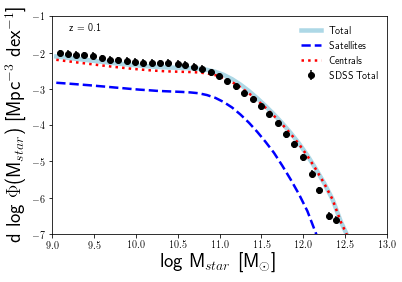

In [51]:
MstarSDSS, phiSDSS = np.loadtxt('z0.1/SDSSMF.txt',skiprows=0,usecols=(0,1),unpack=True)

plt.plot(lgMstarbins,np.log10(Nobs),color='lightblue',linewidth=4.5,label='Total')
plt.plot(lgMstarbins,np.log10(Nobssat),color='blue',linewidth=2.5,linestyle='--',label='Satellites')
plt.plot(lgMstarbins,np.log10(Nobscen),color='red',linewidth=2.5,linestyle=':',label='Centrals')


plt.errorbar(MstarSDSS,phiSDSS,yerr=0.1,color='black',fmt='o',label='SDSS Total')

legend = plt.legend(loc='upper right', shadow=False, frameon=False)
plt.text(9.2, -1.4, r'z = 0.1')
#plt.plot(t, y, ls='--', color='r', linewidth=2)

plt.xlabel(r'log M$_{star}$ [M$_{\odot}$]',fontsize=20)
plt.ylabel(r'd log $\Phi$(M$_{star}$) [Mpc$^{-3}$ dex$^{-1}$]',fontsize=20)
plt.axis([9., 13., -7,-1])

#plt.savefig("z0.1/MstarMFz0.1satcenall.eps")
plt.show()
plt.close()

In [21]:
# Assign BH mass according to Eq5 inclusive of scatter
g_squared = func_g_squared(0.1, Omega_m0, Omega_L0)

b = np.zeros(len(lgMVir_par))
b = estimate_bias(((10.**lgMVir_par)*0.7), 0.1, g_squared)


In [22]:
#Assign BH masses following Eq 5 Shankar + 2019
BhMass = AssignBHMass_EQ5(lgMstar)

In [23]:
logSFR = SFR(0.1,BhMass)

In [22]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = gaussian(eddbin1,1,-2.,0.5)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5gau1a = np.interp(a5,yyg,eddbin1,right=-99)


edd5gau1a = 10.**lgedd5gau1a


#Bolometric L
Lbol5gau1a = (edd5gau1a)*Ledd5
lgLbol5gau1a = np.log10(Lbol5gau1a)-33.49
lglum5gau1a = lgLbol5gau1a - 1.54 - (0.24*(lgLbol5gau1a-12.)) - (0.012*((lgLbol5gau1a-12.)**2.)) + (0.0015*((lgLbol5gau1a-12.)**3.))
lglum5gau1a = lglum5gau1a  + 33.49
lgLbol5gau1a = lgLbol5gau1a  + 33.49




In [23]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = gaussian(eddbin1,1,-2.,1.)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5gau1b = np.interp(a5,yyg,eddbin1,right=-99)


edd5gau1b = 10.**lgedd5gau1b


#Bolometric L
Lbol5gau1b = (edd5gau1b)*Ledd5
lgLbol5gau1b = np.log10(Lbol5gau1b)-33.49
lglum5gau1b = lgLbol5gau1b - 1.54 - (0.24*(lgLbol5gau1b-12.)) - (0.012*((lgLbol5gau1b-12.)**2.)) + (0.0015*((lgLbol5gau1b-12.)**3.))
lglum5gau1b = lglum5gau1b  + 33.49
lgLbol5gau1b = lgLbol5gau1b  + 33.49

In [24]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = gaussian(eddbin1,1,-2.,1.5)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5gau1c = np.interp(a5,yyg,eddbin1,right=-99)


edd5gau1c = 10.**lgedd5gau1c


#Bolometric L
Lbol5gau1c = (edd5gau1c)*Ledd5
lgLbol5gau1c = np.log10(Lbol5gau1c)-33.49
lglum5gau1c = lgLbol5gau1c - 1.54 - (0.24*(lgLbol5gau1c-12.)) - (0.012*((lgLbol5gau1c-12.)**2.)) + (0.0015*((lgLbol5gau1c-12.)**3.))
lglum5gau1c = lglum5gau1c  + 33.49
lgLbol5gau1c = lgLbol5gau1c  + 33.49

In [25]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = gaussian(eddbin1,1,-2.,0.5)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5gau2a = np.interp(a5,yyg,eddbin1,right=-99)


edd5gau2a = 10.**lgedd5gau2a


#Bolometric L
Lbol5gau2a = (edd5gau2a)*Ledd5
lgLbol5gau2a = np.log10(Lbol5gau2a)-33.49
lglum5gau2a = lgLbol5gau2a - 1.54 - (0.24*(lgLbol5gau2a-12.)) - (0.012*((lgLbol5gau2a-12.)**2.)) + (0.0015*((lgLbol5gau2a-12.)**3.))
lglum5gau2a = lglum5gau2a  + 33.49
lgLbol5gau2a = lgLbol5gau2a  + 33.49






In [24]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = gaussian(eddbin1,1,-2.,0.2)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5gau2b = np.interp(a5,yyg,eddbin1,right=-99)


edd5gau2b = 10.**lgedd5gau2b


#Bolometric L
Lbol5gau2b = (edd5gau2b)*Ledd5
lgLbol5gau2b = np.log10(Lbol5gau2b)-33.49
lglum5gau2b = lgLbol5gau2b - 1.54 - (0.24*(lgLbol5gau2b-12.)) - (0.012*((lgLbol5gau2b-12.)**2.)) + (0.0015*((lgLbol5gau2b-12.)**3.))
lglum5gau2b = lglum5gau2b  + 33.49
lgLbol5gau2b = lgLbol5gau2b  + 33.49



In [27]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = gaussian(eddbin1,1,-1.,1.5)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5gau2c = np.interp(a5,yyg,eddbin1,right=-99)


edd5gau2c = 10.**lgedd5gau2c


#Bolometric L
Lbol5gau2c = (edd5gau2c)*Ledd5
lgLbol5gau2c = np.log10(Lbol5gau2c)-33.49
lglum5gau2c = lgLbol5gau2c - 1.54 - (0.24*(lgLbol5gau2c-12.)) - (0.012*((lgLbol5gau2c-12.)**2.)) + (0.0015*((lgLbol5gau2c-12.)**3.))
lglum5gau2c = lglum5gau2c  + 33.49
lgLbol5gau2c = lgLbol5gau2c  + 33.49



In [28]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = gaussian(eddbin1,1,-1.5,0.5)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5gau3a = np.interp(a5,yyg,eddbin1,right=-99)


edd5gau3a = 10.**lgedd5gau3a


#Bolometric L
Lbol5gau3a = (edd5gau3a)*Ledd5
lgLbol5gau3a = np.log10(Lbol5gau3a)-33.49
lglum5gau3a = lgLbol5gau3a - 1.54 - (0.24*(lgLbol5gau3a-12.)) - (0.012*((lgLbol5gau3a-12.)**2.)) + (0.0015*((lgLbol5gau3a-12.)**3.))
lglum5gau3a = lglum5gau3a  + 33.49
lgLbol5gau3a = lgLbol5gau3a  + 33.49



In [29]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = gaussian(eddbin1,1,-1.5,1.)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5gau3b = np.interp(a5,yyg,eddbin1,right=-99)


edd5gau3b = 10.**lgedd5gau3b


#Bolometric L
Lbol5gau3b = (edd5gau3b)*Ledd5
lgLbol5gau3b = np.log10(Lbol5gau3b)-33.49
lglum5gau3b = lgLbol5gau3b - 1.54 - (0.24*(lgLbol5gau3b-12.)) - (0.012*((lgLbol5gau3b-12.)**2.)) + (0.0015*((lgLbol5gau3b-12.)**3.))
lglum5gau3b = lglum5gau3b  + 33.49
lgLbol5gau3b = lgLbol5gau3b  + 33.49



In [30]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = gaussian(eddbin1,1,-1.5,1.5)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5gau3c = np.interp(a5,yyg,eddbin1,right=-99)


edd5gau3c = 10.**lgedd5gau3c


#Bolometric L
Lbol5gau3c = (edd5gau3c)*Ledd5
lgLbol5gau3c = np.log10(Lbol5gau3c)-33.49
lglum5gau3c = lgLbol5gau3c - 1.54 - (0.24*(lgLbol5gau3c-12.)) - (0.012*((lgLbol5gau3c-12.)**2.)) + (0.0015*((lgLbol5gau3c-12.)**3.))
lglum5gau3c = lglum5gau3c  + 33.49
lgLbol5gau3c = lgLbol5gau3c  + 33.49



In [31]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = Schefunc(10.**eddbin1,10.**(-1.),-1.,0.1)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5Sch1a = np.interp(a5,yyg,eddbin1,right=-99)


edd5Sch1a = 10.**lgedd5Sch1a


#Bolometric L
Lbol5Sch1a = (edd5Sch1a)*Ledd5
lgLbol5Sch1a = np.log10(Lbol5Sch1a)-33.49
lglum5Sch1a = lgLbol5Sch1a - 1.54 - (0.24*(lgLbol5Sch1a-12.)) - (0.012*((lgLbol5Sch1a-12.)**2.)) + (0.0015*((lgLbol5Sch1a-12.)**3.))
lglum5Sch1a = lglum5Sch1a  + 33.49
lgLbol5Sch1a = lgLbol5Sch1a  + 33.49





In [32]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = Schefunc(10.**eddbin1,10.**(-1.),-0.7,0.1)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5Sch1b = np.interp(a5,yyg,eddbin1,right=-99)


edd5Sch1b = 10.**lgedd5Sch1b


#Bolometric L
Lbol5Sch1b = (edd5Sch1b)*Ledd5
lgLbol5Sch1b = np.log10(Lbol5Sch1b)-33.49
lglum5Sch1b = lgLbol5Sch1b - 1.54 - (0.24*(lgLbol5Sch1b-12.)) - (0.012*((lgLbol5Sch1b-12.)**2.)) + (0.0015*((lgLbol5Sch1b-12.)**3.))
lglum5Sch1b = lglum5Sch1b  + 33.49
lgLbol5Sch1b = lgLbol5Sch1b  + 33.49




In [33]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = Schefunc(10.**eddbin1,10.**(-1.),-0.5,0.1)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5Sch1c = np.interp(a5,yyg,eddbin1,right=-99)


edd5Sch1c = 10.**lgedd5Sch1c


#Bolometric L
Lbol5Sch1c = (edd5Sch1c)*Ledd5
lgLbol5Sch1c = np.log10(Lbol5Sch1c)-33.49
lglum5Sch1c = lgLbol5Sch1c - 1.54 - (0.24*(lgLbol5Sch1c-12.)) - (0.012*((lgLbol5Sch1c-12.)**2.)) + (0.0015*((lgLbol5Sch1c-12.)**3.))
lglum5Sch1c = lglum5Sch1c  + 33.49
lgLbol5Sch1c = lgLbol5Sch1c  + 33.49




In [34]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = Schefunc(10.**eddbin1,10.**(-1.5),-1.,0.1)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5Sch2a = np.interp(a5,yyg,eddbin1,right=-99)


edd5Sch2a = 10.**lgedd5Sch2a


#Bolometric L
Lbol5Sch2a = (edd5Sch2a)*Ledd5
lgLbol5Sch2a = np.log10(Lbol5Sch2a)-33.49
lglum5Sch2a = lgLbol5Sch2a - 1.54 - (0.24*(lgLbol5Sch2a-12.)) - (0.012*((lgLbol5Sch2a-12.)**2.)) + (0.0015*((lgLbol5Sch2a-12.)**3.))
lglum5Sch2a = lglum5Sch2a  + 33.49
lgLbol5Sch2a = lgLbol5Sch2a  + 33.49




In [49]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = Schefunc(10.**eddbin1,10.**(-1.5),-0.7,0.1)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5Sch2b = np.interp(a5,yyg,eddbin1,right=-99)


edd5Sch2b = 10.**lgedd5Sch2b


#Bolometric L
Lbol5Sch2b = (edd5Sch2b)*Ledd5
lgLbol5Sch2b = np.log10(Lbol5Sch2b)-33.49
lglum5Sch2b = lgLbol5Sch2b - 1.54 - (0.24*(lgLbol5Sch2b-12.)) - (0.012*((lgLbol5Sch2b-12.)**2.)) + (0.0015*((lgLbol5Sch2b-12.)**3.))
lglum5Sch2b = lglum5Sch2b  + 33.49
lgLbol5Sch2b = lgLbol5Sch2b  + 33.49





In [66]:
print np.min(np.log10(Lbol5Sch2b)),np.max(np.log10(Lbol5Sch2b))

14.352168690955345 46.66558855120941


In [36]:
Ledd5=1.28e38*(10.**BhMass)


eddbin1 = np.arange(-4.,0.,0.001,dtype=float)

#Assign Edd ratio following a Gaussian with mean  = -1.8, sigma = 0.5


probg = Schefunc(10.**eddbin1,10.**(-1.5),-0.5,0.1)
p = probg*(10.**0.001)
r_prob = p[::-1]
probcum = np.cumsum(r_prob)
r_probcum = probcum[::-1]
yyg = r_probcum/r_probcum[0]
yyg = yyg[::-1]
eddbin1 = eddbin1[::-1]
a5 = np.random.random(len(BhMass))

lgedd5Sch2c = np.interp(a5,yyg,eddbin1,right=-99)


edd5Sch2c = 10.**lgedd5Sch2c


#Bolometric L
Lbol5Sch2c = (edd5Sch2c)*Ledd5
lgLbol5Sch2c = np.log10(Lbol5Sch2c)-33.49
lglum5Sch2c = lgLbol5Sch2c - 1.54 - (0.24*(lgLbol5Sch2c-12.)) - (0.012*((lgLbol5Sch2c-12.)**2.)) + (0.0015*((lgLbol5Sch2c-12.)**3.))
lglum5Sch2c = lglum5Sch2c  + 33.49
lgLbol5Sch2c = lgLbol5Sch2c  + 33.49



In [37]:
lgMbhbin = np.arange(5.,11.,0.1)
lgMbhbins =  np.ones(len(lgMbhbin)-1)

BHMF =  np.ones(len(lgMbhbin))


volume = (1000.)**3.
binsize = 0.1

for i in range(len(lgMbhbin)-1):
    


    N = np.where((BhMass >= lgMbhbin[i]) & (BhMass < lgMbhbin[i+1]))
    lgMbhbins[i] = (lgMbhbin[i+1] + lgMbhbin[i])/2.
    BHMF[i] = ((len(BhMass[N]))/(volume))/binsize


/astro/home/viola.allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


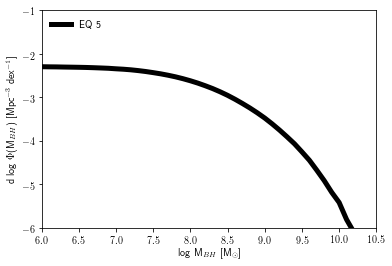

In [63]:
plt.plot(lgMbhbin,np.log10(BHMF),color='k',linewidth=5,label=r'EQ 5')

legend = plt.legend(loc='upper left', shadow=False, frameon=False)

plt.xlabel(r'log M$_{BH}$ [M$_{\odot}$]')
plt.ylabel(r'd log $\Phi$(M$_{BH}$) [Mpc$^{-3}$ dex$^{-1}$]')
plt.axis([6, 10.5, -6,-1])

plt.savefig("z0.1/BHMFz0.1.eps")
plt.show()
plt.close()

In [50]:
cut5  = np.where( (lglum5Sch2b >= 42.) #& (lgMVir_par >= 10.)

lgMhEQ5 = lgMVir_par[cut5]
lgMstarEQ5 = lgMstar[cut5]
lgMhsubEQ5 = lgMVir[cut5]
xEQ5 = x#[cut5]
yEQ5 = y#[cut5]
zEQ5 = z#[cut5]
BhMass_EQ5 = BhMass[cut5]
lgMstarEQ5 = lgMstar[cut5]
bEQ5 = b[cut5]
#lglum5gau1acut = lglum5gau1a#[cut5]
#lglum5gau1bcut = lglum5gau1b#[cut5]
#lglum5gau1ccut = lglum5gau1c#[cut5]

#lglum5Sch1acut = lglum5Sch1a#[cut5]
#lglum5Sch1bcut = lglum5Sch1b#[cut5]
#lglum5Sch1ccut = lglum5Sch1c#[cut5]

#lglum5Sch2acut = lglum5Sch2a#[cut5]
lglum5Sch2bcut = lglum5Sch2b[cut5]
#lglum5Sch2ccut = lglum5Sch2c#[cut5]


#lglum5gau2acut = lglum5gau2a#[cut5]
lglum5gau2bcut = lglum5gau2b[cut5]
#lglum5gau2ccut = lglum5gau2c#[cut5]

#lglum5gau3acut = lglum5gau3a#[cut5]
#lglum5gau3bcut = lglum5gau3b#[cut5]
#lglum5gau3ccut = lglum5gau3c#[cut5]


idh5 = idh[cut5]
#lgedd5gau1acut = lgedd5gau1a#[cut5]
#lgedd5gau1bcut = lgedd5gau1b#[cut5]
#lgedd5gau1ccut = lgedd5gau1c#[cut5]

#lgedd5Sch1acut = lgedd5Sch1a#[cut5]
#lgedd5Sch1bcut = lgedd5Sch1b#[cut5]
#lgedd5Sch1ccut = lgedd5Sch1c#[cut5]

#lgedd5Sch2acut = lgedd5Sch2a#[cut5]
#lgedd5Sch2bcut = lgedd5Sch2b[cut5]
#lgedd5Sch2ccut = lgedd5Sch2c#[cut5]


#lgedd5gau2acut = lgedd5gau2a#[cut5]
#lgedd5gau2bcut = lgedd5gau2b#[cut5]
##lgedd5gau2ccut = lgedd5gau2c#[cut5]

#lgedd5gau3acut = lgedd5gau3a#[cut5]
#lgedd5gau3bcut = lgedd5gau3b#[cut5]
#lgedd5gau3ccut = lgedd5gau3c#[cut5]





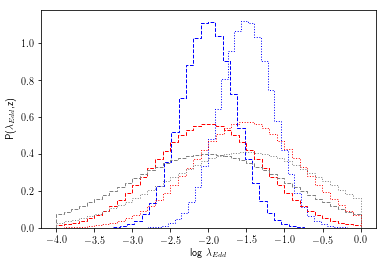

In [29]:
#pyplot.yscale('log',nonposy='clip')
#plt.hist(lgedd5gaucut,bins=40,density=True,color='black',histtype = 'step')
#plt.hist(lgedd5gau2acut,bins=40,density=True,color='blue',histtype = 'step')
#plt.hist(lgedd5gau2acut,bins=40,density=True,color='red',histtype = 'step')
#plt.hist(lgedd5gau2acut,bins=40,density=True,color='grey',histtype = 'step')

plt.hist(lgedd5gau1acut,bins=40,density=True,color='blue',histtype = 'step',linestyle='--')
plt.hist(lgedd5gau1bcut,bins=40,density=True,color='red',histtype = 'step',linestyle='--')
plt.hist(lgedd5gau1ccut,bins=40,density=True,color='grey',histtype = 'step',linestyle='--')

plt.hist(lgedd5gau3acut,bins=40,density=True,color='blue',histtype = 'step',linestyle=':')
plt.hist(lgedd5gau3bcut,bins=40,density=True,color='red',histtype = 'step',linestyle=':')
plt.hist(lgedd5gau3ccut,bins=40,density=True,color='grey',histtype = 'step',linestyle=':')



plt.xlabel(r'log $\lambda_{Edd}$')
plt.ylabel(r'P($\lambda_{Edd}$,z)')
#handles = [Rectangle((0,0),1,1,facecolor="white",ec="black"),Rectangle((0,0),1,1,facecolor="white",ec="blue")]
#labels= ["Gaussian", "Schechter"]
#plt.legend(handles, labels,frameon=False,loc='upper right')
#plt.axis([-1.5, 0.5, -6,-1])
#plt.savefig("z0.1/edddistr.eps")
plt.show()
plt.close()




In [33]:
#Assign NH values following Ueda et al.

lgNH = np.arange(20.,26.,0.01)

fLxzNH = np.ones(len(lgNH))
fLxzNH_cum = np.ones(len(lgNH))

lgNHEQ5 = np.ones(len(lglum5cut))

#z = 1.1 #redshift

lgLxbin = np.arange(42.,48.,0.01)


for i in range(len(lgLxbin)-1):
    
    
    flag  = np.where((lglum5cut >=lgLxbin[i]) & (lglum5cut < lgLxbin[i+1]))
   
    fLxzNH  = (NHfunc(lgLxbin[i],0.1,lgNH))
    fLxzNH = fLxzNH*0.01
    fLxzNH_= fLxzNH[::-1]
    fLxzNH_cum = np.cumsum(fLxzNH_)
    r_fLxzNH_cum  = fLxzNH_cum[::-1]
    yy = r_fLxzNH_cum/ r_fLxzNH_cum[0]
    yy = yy[::-1]
    lgNH = lgNH[::-1]
    a = random.random()
    
    lgNHEQ5[flag] = np.interp(a,yy,lgNH,right=-99)

print (lgNHEQ5)

NameError: name 'lglum5cut' is not defined

In [27]:
BH = np.arange(5,11,0.1)
duty = np.ones(len(BH))
duty1 = duty*0.7
duty2 = duty*0.3
duty3 = duty*0.1

In [35]:
BH, duty = np.loadtxt('Schulze0.1.txt',skiprows=0,usecols=(0,1),unpack=True)
BH05, duty05 = np.loadtxt('Schulzez0.6.txt',skiprows=0,usecols=(0,1),unpack=True)
BH1, duty1 = np.loadtxt('Schulzez1.txt',skiprows=0,usecols=(0,1),unpack=True)

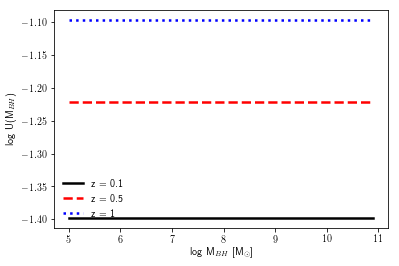

In [39]:

plt.plot(BH,np.log10((duty1)),color='k',linewidth=2.5,label=r'z = 0.1')
plt.plot(BH,np.log10((duty2)),color='r',linewidth=2.5,linestyle='--',label=r'z = 0.5')
plt.plot(BH,np.log10((duty3)),color='b',linewidth=2.5,linestyle=':',label=r'z = 1')



legend = plt.legend(loc='lower left', shadow=False, frameon=False)

plt.xlabel(r'log M$_{BH}$ [M$_{\odot}$]')
plt.ylabel(r'log U(M$_{BH}$)')
plt.axis([5, 9.5, -2.,-1.])
#plt.savefig("dutycyall.eps")
plt.show()
plt.close()

In [51]:
#Assign duty cycle following Schulze + 2015
fEQ51 = np.zeros(len(BhMass_EQ5))
fEQ52 = np.zeros(len(BhMass_EQ5))
fEQ53 = np.zeros(len(BhMass_EQ5))
fEQ54 = np.zeros(len(BhMass_EQ5))



for i in range(len(BH)-1):
    N = np.where( ( BhMass_EQ5 >=  BH[i] ) & ( BhMass_EQ5 < BH[i+1]) )
    fEQ51[N] = (duty1[i])
    
    fEQ52[N] = (duty2[i])

    fEQ53[N] = (duty3[i])

    #fEQ54[N] = (duty4[i])

In [68]:
volume = (1000.)**3.


lgMbhbin1 = np.arange(5.,11.,0.5)

acBHMFEQ51 =  np.ones(len(lgMbhbin1))
acBHMFEQ52 =  np.ones(len(lgMbhbin1))
acBHMFEQ53 =  np.ones(len(lgMbhbin1))




for i in range(len(lgMbhbin1)-1):
    

    N = np.where((BhMass_EQ5 >= lgMbhbin1[i]) & (BhMass_EQ5 < lgMbhbin1[i+1]))
    acBHMFEQ51[i] = ((np.sum(fEQ51[N]))/((volume)))/0.5
    acBHMFEQ52[i] = ((np.sum(fEQ52[N]))/((volume)))/0.5
    acBHMFEQ53[i] = ((np.sum(fEQ53[N]))/((volume)))/0.5


#np.savetxt('z0.1/activeBHMF0.1.txt',np.column_stack((lgMbhbin1,acBHMFEQ5)))       




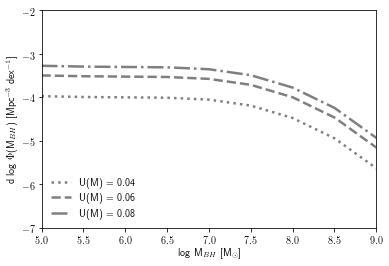

In [69]:
plt.plot(lgMbhbin1,np.log10(acBHMFEQ51),color='k',linewidth=2.5,linestyle=':',label=r'U(M) = 0.01',alpha=0.5)
plt.plot(lgMbhbin1,np.log10(acBHMFEQ52),color='k',linewidth=2.5,linestyle='--',label=r'U(M) = 0.05',alpha=0.5)
plt.plot(lgMbhbin1,np.log10(acBHMFEQ53),color='k',linewidth=2.5,linestyle='-.',label=r'U(M) = 0.1',alpha=0.5)


#plt.plot(lgMbhbin,np.log10(BHMFEQ5),color='r',linewidth=2.5,label=r'BHMF')


#plt.text(8.2, -13, r'z = 0.25')
legend = plt.legend(loc='lower left', shadow=False, frameon=False)
plt.xlabel(r'log M$_{BH}$ [M$_{\odot}$]')
plt.ylabel(r'd log $\Phi$(M$_{BH}$) [Mpc$^{-3}$ dex$^{-1}$]')
plt.axis([5., 9., -7,-2.])             
plt.savefig("z0.1/acBHMF.eps")
plt.show()
plt.close()

In [43]:
volume = (1000./0.7)**3.
binsize = 0.1


lglumbin = np.arange(42.,45.,0.1)
lglumbins = np.zeros(len(lglumbin)-1)


XLFEQ51a_1 = np.zeros(len(lglumbin)-1)
XLFEQ51b_1 = np.zeros(len(lglumbin)-1)
XLFEQ51c_1 = np.zeros(len(lglumbin)-1)

XLFEQ51a_2 = np.zeros(len(lglumbin)-1)
XLFEQ51b_2 = np.zeros(len(lglumbin)-1)
XLFEQ51c_2 = np.zeros(len(lglumbin)-1)

XLFEQ51a_3 = np.zeros(len(lglumbin)-1)
XLFEQ51b_3 = np.zeros(len(lglumbin)-1)
XLFEQ51c_3 = np.zeros(len(lglumbin)-1)



for i in range(len(lglumbin)-1):
    
    lglumbins[i] = (lglumbin[i+1]+lglumbin[i])/2.
    N = np.where((lglum5gau1acut >= lglumbin[i]) & (lglum5gau1acut < lglumbin[i+1]))
    XLFEQ51a_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
    N = np.where((lglum5gau1bcut >= lglumbin[i]) & (lglum5gau1bcut < lglumbin[i+1]))
    XLFEQ51b_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
    N = np.where((lglum5gau1ccut >= lglumbin[i]) & (lglum5gau1ccut < lglumbin[i+1]))
    XLFEQ51c_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)

    N = np.where((lglum5gau1acut >= lglumbin[i]) & (lglum5gau1acut < lglumbin[i+1]))
    XLFEQ51a_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    N = np.where((lglum5gau1bcut >= lglumbin[i]) & (lglum5gau1bcut < lglumbin[i+1]))
    XLFEQ51b_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    N = np.where((lglum5gau1ccut >= lglumbin[i]) & (lglum5gau1ccut < lglumbin[i+1]))
    XLFEQ51c_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)


    N = np.where((lglum5gau1acut >= lglumbin[i]) & (lglum5gau1acut < lglumbin[i+1]))
    XLFEQ51a_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    N = np.where((lglum5gau1bcut >= lglumbin[i]) & (lglum5gau1bcut < lglumbin[i+1]))
    XLFEQ51b_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    N = np.where((lglum5gau1ccut >= lglumbin[i]) & (lglum5gau1ccut < lglumbin[i+1]))
    XLFEQ51c_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)



#np.savetxt('z0.1/XLF0.1Sch.txt',np.column_stack((lglumbins,XLFEQ5)))       



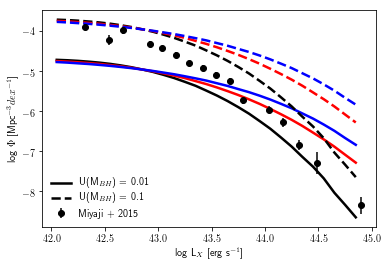

In [96]:
logLxMi,phiM, err = np.loadtxt('Miyaji2015z0.1.txt',skiprows=0,usecols=(0,1,2),unpack=True)
err = np.log10(phiM+err)-np.log10(phiM)
plt.errorbar(logLxMi, np.log10(phiM),yerr=err,fmt='o',label='Miyaji + 2015',color='black')
plt.plot(lglumbins,np.log10(XLFEQ51a_1),color='black',ls='-',linewidth=2.5,label='U(M$_{BH}$) = 0.01')
plt.plot(lglumbins,np.log10(XLFEQ51b_1),color='Red',ls='-',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQ51c_1),color='blue',ls='-',linewidth=2.5)

#plt.plot(lglumbins,np.log10(XLFEQ51a_2),color='black',ls=':',linewidth=2.5,label='U(M$_{BH}$) = 0.05')
#plt.plot(lglumbins,np.log10(XLFEQ51b_2),color='Red',ls=':',linewidth=2.5)
#plt.plot(lglumbins,np.log10(XLFEQ51c_2),color='blue',ls=':',linewidth=2.5)

plt.plot(lglumbins,np.log10(XLFEQ51a_3),color='black',ls='--',linewidth=2.5,label='U(M$_{BH}$) = 0.1')
plt.plot(lglumbins,np.log10(XLFEQ51b_3),color='Red',ls='--',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQ51c_3),color='blue',ls='--',linewidth=2.5)


#plt.plot(lglumbins,np.log10(XLFEQ5a),color='blue',ls='-',linewidth=2.5,label='Aird')
#plt.plot(lglumbins,np.log10(XLFEQ5b),color='grey',ls=':',linewidth=2.5,label='-3.5,0')




plt.legend(loc='lower left', shadow=False, frameon=False)
plt.xlabel(r'log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel(r'log $\Phi$ [Mpc$^{-3} dex^{-1}$]')
plt.savefig("z0.1/XLFz0.1_1a.eps")
plt.show()
plt.close()

In [44]:
volume = (1000./0.7)**3.
binsize = 0.1


lglumbin = np.arange(42.,45.,0.1)
lglumbins = np.zeros(len(lglumbin)-1)


XLFEQSch51a_1 = np.zeros(len(lglumbin)-1)
XLFEQSch51b_1 = np.zeros(len(lglumbin)-1)
XLFEQSch51c_1 = np.zeros(len(lglumbin)-1)

XLFEQSch51a_2 = np.zeros(len(lglumbin)-1)
XLFEQSch51b_2 = np.zeros(len(lglumbin)-1)
XLFEQSch51c_2 = np.zeros(len(lglumbin)-1)

XLFEQSch51a_3 = np.zeros(len(lglumbin)-1)
XLFEQSch51b_3 = np.zeros(len(lglumbin)-1)
XLFEQSch51c_3 = np.zeros(len(lglumbin)-1)



for i in range(len(lglumbin)-1):
    
    lglumbins[i] = (lglumbin[i+1]+lglumbin[i])/2.
    N = np.where((lglum5Sch1acut >= lglumbin[i]) & (lglum5Sch1acut < lglumbin[i+1]))
    XLFEQSch51a_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
    N = np.where((lglum5Sch1bcut >= lglumbin[i]) & (lglum5Sch1bcut < lglumbin[i+1]))
    XLFEQSch51b_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
    N = np.where((lglum5Sch1ccut >= lglumbin[i]) & (lglum5Sch1ccut < lglumbin[i+1]))
    XLFEQSch51c_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)

    N = np.where((lglum5Sch1acut >= lglumbin[i]) & (lglum5Sch1acut < lglumbin[i+1]))
    XLFEQSch51a_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    N = np.where((lglum5Sch1bcut >= lglumbin[i]) & (lglum5Sch1bcut < lglumbin[i+1]))
    XLFEQSch51b_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    N = np.where((lglum5Sch1ccut >= lglumbin[i]) & (lglum5Sch1ccut < lglumbin[i+1]))
    XLFEQSch51c_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)


    N = np.where((lglum5Sch1acut >= lglumbin[i]) & (lglum5Sch1acut < lglumbin[i+1]))
    XLFEQSch51a_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    N = np.where((lglum5Sch1bcut >= lglumbin[i]) & (lglum5Sch1bcut < lglumbin[i+1]))
    XLFEQSch51b_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    N = np.where((lglum5Sch1ccut >= lglumbin[i]) & (lglum5Sch1ccut < lglumbin[i+1]))
    XLFEQSch51c_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)




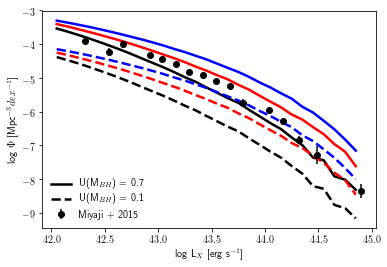

In [97]:
logLxMi,phiM, err = np.loadtxt('Miyaji2015z0.1.txt',skiprows=0,usecols=(0,1,2),unpack=True)
err = np.log10(phiM+err)-np.log10(phiM)
plt.errorbar(logLxMi, np.log10(phiM),yerr=err,fmt='o',label='Miyaji + 2015',color='black')
plt.plot(lglumbins,np.log10(XLFEQSch51a_1),color='black',ls='-',linewidth=2.5,label='U(M$_{BH}$) = 0.7')
plt.plot(lglumbins,np.log10(XLFEQSch51b_1),color='Red',ls='-',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQSch51c_1),color='blue',ls='-',linewidth=2.5)

#plt.plot(lglumbins,np.log10(XLFEQSch51a_2),color='black',ls=':',linewidth=2.5,label='U(M$_{BH}$) = 0.05')
#plt.plot(lglumbins,np.log10(XLFEQSch51b_2),color='Red',ls=':',linewidth=2.5)
#plt.plot(lglumbins,np.log10(XLFEQSch51c_2),color='blue',ls=':',linewidth=2.5)

plt.plot(lglumbins,np.log10(XLFEQSch51a_3),color='black',ls='--',linewidth=2.5,label='U(M$_{BH}$) = 0.1')
plt.plot(lglumbins,np.log10(XLFEQSch51b_3),color='Red',ls='--',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQSch51c_3),color='blue',ls='--',linewidth=2.5)


#plt.plot(lglumbins,np.log10(XLFEQ5a),color='blue',ls='-',linewidth=2.5,label='Aird')
#plt.plot(lglumbins,np.log10(XLFEQ5b),color='grey',ls=':',linewidth=2.5,label='-3.5,0')




plt.legend(loc='lower left', shadow=False, frameon=False)
plt.xlabel(r'log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel(r'log $\Phi$ [Mpc$^{-3} dex^{-1}$]')
plt.savefig("z0.1/XLFz0.1_1Sch.eps")
plt.show()
plt.close()

In [52]:
volume = (1000./0.7)**3.
binsize = 0.1


lglumbin = np.arange(42.,45.,0.1)
lglumbins = np.zeros(len(lglumbin)-1)


XLFEQSch52a_1 = np.zeros(len(lglumbin)-1)
XLFEQSch52b_1 = np.zeros(len(lglumbin)-1)
XLFEQSch52c_1 = np.zeros(len(lglumbin)-1)

XLFEQSch52a_2 = np.zeros(len(lglumbin)-1)
XLFEQSch52b_2 = np.zeros(len(lglumbin)-1)
XLFEQSch52c_2 = np.zeros(len(lglumbin)-1)

XLFEQSch52a_3 = np.zeros(len(lglumbin)-1)
XLFEQSch52b_3 = np.zeros(len(lglumbin)-1)
XLFEQSch52c_3 = np.zeros(len(lglumbin)-1)



for i in range(len(lglumbin)-1):
    
    lglumbins[i] = (lglumbin[i+1]+lglumbin[i])/2.
    #N = np.where((lglum5Sch2acut >= lglumbin[i]) & (lglum5Sch2acut < lglumbin[i+1]))
    #XLFEQSch52a_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
    N = np.where((lglum5Sch2bcut >= lglumbin[i]) & (lglum5Sch2bcut < lglumbin[i+1]))
    XLFEQSch52b_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
   # N = np.where((lglum5Sch2ccut >= lglumbin[i]) & (lglum5Sch2ccut < lglumbin[i+1]))
    #XLFEQSch52c_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)

    #N = np.where((lglum5Sch1acut >= lglumbin[i]) & (lglum5Sch1acut < lglumbin[i+1]))
    #XLFEQSch52a_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    #N = np.where((lglum5Sch2bcut >= lglumbin[i]) & (lglum5Sch2bcut < lglumbin[i+1]))
    #XLFEQSch52b_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    #N = np.where((lglum5Sch2ccut >= lglumbin[i]) & (lglum5Sch2ccut < lglumbin[i+1]))
    #XLFEQSch52c_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)


    #N = np.where((lglum5Sch2acut >= lglumbin[i]) & (lglum5Sch2acut < lglumbin[i+1]))
    #XLFEQSch52a_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    #N = np.where((lglum5Sch2bcut >= lglumbin[i]) & (lglum5Sch2bcut < lglumbin[i+1]))
    #XLFEQSch52b_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    #N = np.where((lglum5Sch2ccut >= lglumbin[i]) & (lglum5Sch2ccut < lglumbin[i+1]))
    #XLFEQSch52c_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)



/astro/home/viola.allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/astro/home/viola.allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


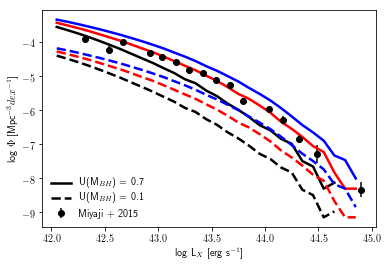

In [98]:
logLxMi,phiM, err = np.loadtxt('Miyaji2015z0.1.txt',skiprows=0,usecols=(0,1,2),unpack=True)
err = np.log10(phiM+err)-np.log10(phiM)
plt.errorbar(logLxMi, np.log10(phiM),yerr=err,fmt='o',label='Miyaji + 2015',color='black')
plt.plot(lglumbins,np.log10(XLFEQSch52a_1),color='black',ls='-',linewidth=2.5,label='U(M$_{BH}$) = 0.7')
plt.plot(lglumbins,np.log10(XLFEQSch52b_1),color='Red',ls='-',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQSch52c_1),color='blue',ls='-',linewidth=2.5)

#plt.plot(lglumbins,np.log10(XLFEQSch52a_2),color='black',ls=':',linewidth=2.5,label='U(M$_{BH}$) = 0.05')
#plt.plot(lglumbins,np.log10(XLFEQSch52b_2),color='Red',ls=':',linewidth=2.5)
#plt.plot(lglumbins,np.log10(XLFEQSch52c_2),color='blue',ls=':',linewidth=2.5)

plt.plot(lglumbins,np.log10(XLFEQSch52a_3),color='black',ls='--',linewidth=2.5,label='U(M$_{BH}$) = 0.1')
plt.plot(lglumbins,np.log10(XLFEQSch52b_3),color='Red',ls='--',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQSch52c_3),color='blue',ls='--',linewidth=2.5)


#plt.plot(lglumbins,np.log10(XLFEQ5a),color='blue',ls='-',linewidth=2.5,label='Aird')
#plt.plot(lglumbins,np.log10(XLFEQ5b),color='grey',ls=':',linewidth=2.5,label='-3.5,0')




plt.legend(loc='lower left', shadow=False, frameon=False)
plt.xlabel(r'log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel(r'log $\Phi$ [Mpc$^{-3} dex^{-1}$]')
plt.savefig("z0.1/XLFz0.1_2Sch.eps")
plt.show()
plt.close()

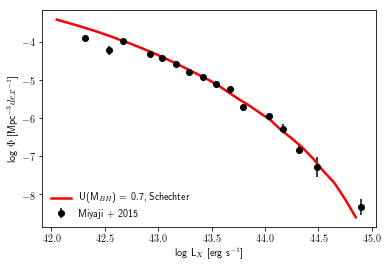

In [46]:
logLxMi,phiM, err = np.loadtxt('Miyaji2015z0.1.txt',skiprows=0,usecols=(0,1,2),unpack=True)
err = np.log10(phiM+err)-np.log10(phiM)
plt.errorbar(logLxMi, np.log10(phiM),yerr=err,fmt='o',label='Miyaji + 2015',color='black')
#plt.plot(lglumbins,np.log10(XLFEQSch52a_1),color='black',ls='-',linewidth=2.5,label='U(M$_{BH}$) = 0.7')
plt.plot(lglumbins,np.log10(XLFEQSch52b_1),color='Red',ls='-',linewidth=2.5,label='U(M$_{BH}$) = 0.7, Schechter')
#plt.plot(lglumbins,np.log10(XLFEQSch52c_1),color='blue',ls='-',linewidth=2.5)

#plt.plot(lglumbins,np.log10(XLFEQSch52a_2),color='black',ls=':',linewidth=2.5,label='U(M$_{BH}$) = 0.05')
#plt.plot(lglumbins,np.log10(XLFEQSch52b_2),color='Red',ls=':',linewidth=2.5)
#plt.plot(lglumbins,np.log10(XLFEQSch52c_2),color='blue',ls=':',linewidth=2.5)

#plt.plot(lglumbins,np.log10(XLFEQSch52a_3),color='black',ls='--',linewidth=2.5,label='U(M$_{BH}$) = 0.1')
#plt.plot(lglumbins,np.log10(XLFEQSch52b_3),color='Red',ls='--',linewidth=2.5)
#plt.plot(lglumbins,np.log10(XLFEQSch52c_3),color='blue',ls='--',linewidth=2.5)


#plt.plot(lglumbins,np.log10(XLFEQ5a),color='blue',ls='-',linewidth=2.5,label='Aird')
#plt.plot(lglumbins,np.log10(XLFEQ5b),color='grey',ls=':',linewidth=2.5,label='-3.5,0')




plt.legend(loc='lower left', shadow=False, frameon=False)
plt.xlabel(r'log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel(r'log $\Phi$ [Mpc$^{-3} dex^{-1}$]')
plt.savefig("z0.1/XLFz0.1Sch.eps")
plt.show()
plt.close()

In [61]:
bins = np.arange(32.,35.,0.2)
#lxbin = np.arange(41.,45.,0.2)
#mstbin = np.arange(7.,11.,0.2)


#pA = Aird12(10.**lxbin,10.**mstbin,0.1)
pB = Bon12(10.**bins)

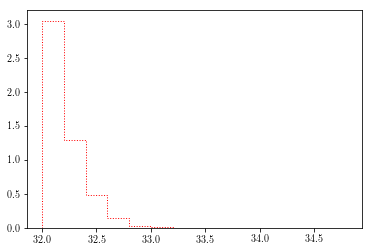

In [62]:
p = plt.hist(np.log10((10.**lglum5Sch2bcut)/10.**lgMstarEQ5),bins=bins,weights=fEQ51,density=True,color='red',histtype = 'step',linestyle=':')

In [60]:
print np.min(np.log10((10.**lglum5Sch2bcut/(0.7*0.7))/10.**lgMstarEQ5)),np.max(np.log10(10.**lglum5Sch2bcut/10.**lgMstarEQ5))

29.928072165956955 33.42438341296219


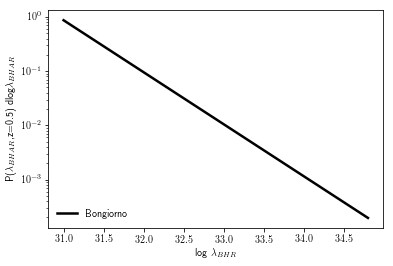

In [36]:
pyplot.yscale('log',nonposy='clip')


plt.plot(bins,(pB)*(10.**0.2),color='k',linewidth=2.5,label=r'Bongiorno')
plt.plot(bins,(p)*(10.**0.2),color='k',linewidth=2.5,label=r'Bongiorno')




legend = plt.legend(loc='lower left', shadow=False, frameon=False)

plt.xlabel(r'log $\lambda_{BHAR}$')
plt.ylabel(r'P($\lambda_{BHAR}$,z=0.5) dlog$\lambda_{BHAR}$')

#plt.axis([-4, 0.1, 0,1])
plt.savefig("z0.1/PBHAR.eps")
plt.show()
plt.close()

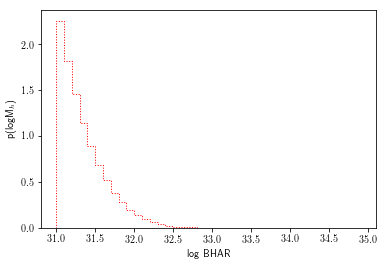

In [28]:

bins = np.arange(31.,35.,0.1)

#ntot = plt.hist(lgMhEQ5,bins=bins,color='grey',histtype = 'stepfilled')
#n = plt.hist(lgMhEQ5,bins=bins,weights=fEQ5,density=True,color='black',histtype = 'step')
p = plt.hist(np.log10(10.**lglum5Sch2bcut/10.**lgMstarEQ5),bins=bins,weights=fEQ51,density=True,color='red',histtype = 'step',linestyle=':')


plt.xlabel(r'log BHAR')
plt.ylabel(r'p(logM$_{h}$)')
#handles = [Rectangle((0,0),1,1,facecolor="white",ec="blue",linestyle=':'),Rectangle((0,0),1,1,facecolor="white",ec="red",linestyle=':'),Rectangle((0,0),1,1,facecolor="white",ec="blue"),Rectangle((0,0),1,1,facecolor="white",ec="red")]

#labels= ["Satellites Type 1","Centrals Type 1","Satellites Type 2","Centrals Type 2"]
#plt.legend(handles, labels,frameon=False,loc='upper right')


#plt.axis([6, 9.5, -6,-1])
plt.savefig("z0.1/PBHAR.eps")
plt.show()
plt.close()




In [58]:
volume = (1000./0.7)**3.
binsize = 0.1


lglumbin = np.arange(42.,45.,0.1)
lglumbins = np.zeros(len(lglumbin)-1)


XLFEQ52a_1 = np.zeros(len(lglumbin)-1)
XLFEQ52b_1 = np.zeros(len(lglumbin)-1)




for i in range(len(lglumbin)-1):
    
    lglumbins[i] = (lglumbin[i+1]+lglumbin[i])/2.
    N = np.where((lglum5gau2acut >= lglumbin[i]) & (lglum5gau2acut < lglumbin[i+1]))
    XLFEQ52a_1[i]   = (np.sum(fEQ54[N]))/( volume)/(binsize)
    N = np.where((lglum5gau2bcut >= lglumbin[i]) & (lglum5gau2bcut < lglumbin[i+1]))
    XLFEQ52b_1[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)


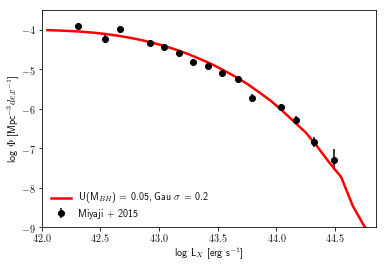

In [100]:
logLxMi,phiM, err = np.loadtxt('Miyaji2015z0.1.txt',skiprows=0,usecols=(0,1,2),unpack=True)
err = np.log10(phiM+err)-np.log10(phiM)
plt.errorbar(logLxMi, np.log10(phiM),yerr=err,fmt='o',label='Miyaji + 2015',color='black')
#plt.plot(lglumbins,np.log10(XLFEQ52a_1),color='black',ls='-',linewidth=2.5,label='U(M$_{BH}$) = 0.04, sig = 0.5')
plt.plot(lglumbins,np.log10(XLFEQ52b_1),color='Red',ls='-',linewidth=2.5,label='U(M$_{BH}$) = 0.05, Gau $\sigma$ = 0.2')

#plt.plot(lglumbins,np.log10(XLFEQ51a_2),color='black',ls=':',linewidth=2.5,label='U(M$_{BH}$) = 0.05')
#plt.plot(lglumbins,np.log10(XLFEQ51b_2),color='Red',ls=':',linewidth=2.5)
#plt.plot(lglumbins,np.log10(XLFEQ51c_2),color='blue',ls=':',linewidth=2.5)


#plt.plot(lglumbins,np.log10(XLFEQ5a),color='blue',ls='-',linewidth=2.5,label='Aird')
#plt.plot(lglumbins,np.log10(XLFEQ5b),color='grey',ls=':',linewidth=2.5,label='-3.5,0')




plt.legend(loc='lower left', shadow=False, frameon=False)
plt.xlabel(r'log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel(r'log $\Phi$ [Mpc$^{-3} dex^{-1}$]')
plt.axis([42., 44.85, -9,-3.5])             

plt.savefig("z0.1/XLFz0.1gau.eps")
plt.show()
plt.close()

In [77]:
volume = (1000./0.7)**3.
binsize = 0.1


lglumbin = np.arange(42.,45.,0.1)
lglumbins = np.zeros(len(lglumbin)-1)


XLFEQ52a_1 = np.zeros(len(lglumbin)-1)
XLFEQ52b_1 = np.zeros(len(lglumbin)-1)
XLFEQ52c_1 = np.zeros(len(lglumbin)-1)

XLFEQ52a_2 = np.zeros(len(lglumbin)-1)
XLFEQ52b_2 = np.zeros(len(lglumbin)-1)
XLFEQ52c_2 = np.zeros(len(lglumbin)-1)

XLFEQ52a_3 = np.zeros(len(lglumbin)-1)
XLFEQ52b_3 = np.zeros(len(lglumbin)-1)
XLFEQ52c_3 = np.zeros(len(lglumbin)-1)



for i in range(len(lglumbin)-1):
    
    lglumbins[i] = (lglumbin[i+1]+lglumbin[i])/2.
    N = np.where((lglum5gau2acut >= lglumbin[i]) & (lglum5gau2acut < lglumbin[i+1]))
    XLFEQ52a_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
    N = np.where((lglum5gau2bcut >= lglumbin[i]) & (lglum5gau2bcut < lglumbin[i+1]))
    XLFEQ52b_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
    N = np.where((lglum5gau2ccut >= lglumbin[i]) & (lglum5gau2ccut < lglumbin[i+1]))
    XLFEQ52c_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)

    N = np.where((lglum5gau2acut >= lglumbin[i]) & (lglum5gau2acut < lglumbin[i+1]))
    XLFEQ52a_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    N = np.where((lglum5gau2bcut >= lglumbin[i]) & (lglum5gau2bcut < lglumbin[i+1]))
    XLFEQ52b_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    N = np.where((lglum5gau2ccut >= lglumbin[i]) & (lglum5gau2ccut < lglumbin[i+1]))
    XLFEQ52c_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)


    N = np.where((lglum5gau2acut >= lglumbin[i]) & (lglum5gau2acut < lglumbin[i+1]))
    XLFEQ52a_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    N = np.where((lglum5gau2bcut >= lglumbin[i]) & (lglum5gau2bcut < lglumbin[i+1]))
    XLFEQ52b_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    N = np.where((lglum5gau2ccut >= lglumbin[i]) & (lglum5gau2ccut < lglumbin[i+1]))
    XLFEQ52c_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)





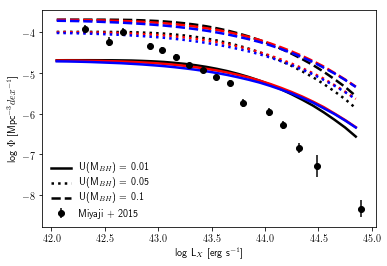

In [78]:
logLxMi,phiM, err = np.loadtxt('Miyaji2015z0.1.txt',skiprows=0,usecols=(0,1,2),unpack=True)
err = np.log10(phiM+err)-np.log10(phiM)
plt.errorbar(logLxMi, np.log10(phiM),yerr=err,fmt='o',label='Miyaji + 2015',color='black')
plt.plot(lglumbins,np.log10(XLFEQ52a_1),color='black',ls='-',linewidth=2.5,label='U(M$_{BH}$) = 0.01')
plt.plot(lglumbins,np.log10(XLFEQ52b_1),color='Red',ls='-',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQ52c_1),color='blue',ls='-',linewidth=2.5)

plt.plot(lglumbins,np.log10(XLFEQ52a_2),color='black',ls=':',linewidth=2.5,label='U(M$_{BH}$) = 0.05')
plt.plot(lglumbins,np.log10(XLFEQ52b_2),color='Red',ls=':',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQ52c_2),color='blue',ls=':',linewidth=2.5)

plt.plot(lglumbins,np.log10(XLFEQ52a_3),color='black',ls='--',linewidth=2.5,label='U(M$_{BH}$) = 0.1')
plt.plot(lglumbins,np.log10(XLFEQ52b_3),color='Red',ls='--',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQ52c_3),color='blue',ls='--',linewidth=2.5)


#plt.plot(lglumbins,np.log10(XLFEQ5a),color='blue',ls='-',linewidth=2.5,label='Aird')
#plt.plot(lglumbins,np.log10(XLFEQ5b),color='grey',ls=':',linewidth=2.5,label='-3.5,0')




plt.legend(loc='lower left', shadow=False, frameon=False)
plt.xlabel(r'log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel(r'log $\Phi$ [Mpc$^{-3} dex^{-1}$]')
plt.savefig("z0.1/XLFz0.1_2.png")
plt.show()
plt.close()

In [79]:
volume = (1000./0.7)**3.
binsize = 0.1


lglumbin = np.arange(42.,45.,0.1)
lglumbins = np.zeros(len(lglumbin)-1)


XLFEQ53a_1 = np.zeros(len(lglumbin)-1)
XLFEQ53b_1 = np.zeros(len(lglumbin)-1)
XLFEQ53c_1 = np.zeros(len(lglumbin)-1)

XLFEQ53a_2 = np.zeros(len(lglumbin)-1)
XLFEQ53b_2 = np.zeros(len(lglumbin)-1)
XLFEQ53c_2 = np.zeros(len(lglumbin)-1)

XLFEQ53a_3 = np.zeros(len(lglumbin)-1)
XLFEQ53b_3 = np.zeros(len(lglumbin)-1)
XLFEQ53c_3 = np.zeros(len(lglumbin)-1)



for i in range(len(lglumbin)-1):
    
    lglumbins[i] = (lglumbin[i+1]+lglumbin[i])/2.
    N = np.where((lglum5gau3acut >= lglumbin[i]) & (lglum5gau3acut < lglumbin[i+1]))
    XLFEQ53a_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
    N = np.where((lglum5gau3bcut >= lglumbin[i]) & (lglum5gau3bcut < lglumbin[i+1]))
    XLFEQ53b_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)
    N = np.where((lglum5gau3ccut >= lglumbin[i]) & (lglum5gau3ccut < lglumbin[i+1]))
    XLFEQ53c_1[i]   = (np.sum(fEQ51[N]))/( volume)/(binsize)

    N = np.where((lglum5gau3acut >= lglumbin[i]) & (lglum5gau3acut < lglumbin[i+1]))
    XLFEQ53a_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    N = np.where((lglum5gau3bcut >= lglumbin[i]) & (lglum5gau3bcut < lglumbin[i+1]))
    XLFEQ53b_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)
    N = np.where((lglum5gau3ccut >= lglumbin[i]) & (lglum5gau3ccut < lglumbin[i+1]))
    XLFEQ53c_2[i]   = (np.sum(fEQ52[N]))/( volume)/(binsize)


    N = np.where((lglum5gau3acut >= lglumbin[i]) & (lglum5gau3acut < lglumbin[i+1]))
    XLFEQ53a_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    N = np.where((lglum5gau3bcut >= lglumbin[i]) & (lglum5gau3bcut < lglumbin[i+1]))
    XLFEQ53b_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)
    N = np.where((lglum5gau3ccut >= lglumbin[i]) & (lglum5gau3ccut < lglumbin[i+1]))
    XLFEQ53c_3[i]   = (np.sum(fEQ53[N]))/( volume)/(binsize)






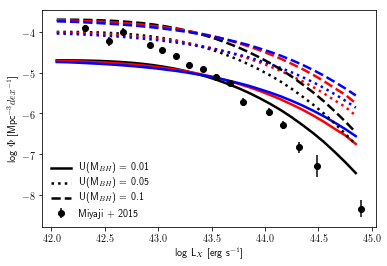

In [80]:
logLxMi,phiM, err = np.loadtxt('Miyaji2015z0.1.txt',skiprows=0,usecols=(0,1,2),unpack=True)
err = np.log10(phiM+err)-np.log10(phiM)
plt.errorbar(logLxMi, np.log10(phiM),yerr=err,fmt='o',label='Miyaji + 2015',color='black')
plt.plot(lglumbins,np.log10(XLFEQ53a_1),color='black',ls='-',linewidth=2.5,label='U(M$_{BH}$) = 0.01')
plt.plot(lglumbins,np.log10(XLFEQ53b_1),color='Red',ls='-',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQ53c_1),color='blue',ls='-',linewidth=2.5)

plt.plot(lglumbins,np.log10(XLFEQ53a_2),color='black',ls=':',linewidth=2.5,label='U(M$_{BH}$) = 0.05')
plt.plot(lglumbins,np.log10(XLFEQ53b_2),color='Red',ls=':',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQ53c_2),color='blue',ls=':',linewidth=2.5)

plt.plot(lglumbins,np.log10(XLFEQ53a_3),color='black',ls='--',linewidth=2.5,label='U(M$_{BH}$) = 0.1')
plt.plot(lglumbins,np.log10(XLFEQ53b_3),color='Red',ls='--',linewidth=2.5)
plt.plot(lglumbins,np.log10(XLFEQ53c_3),color='blue',ls='--',linewidth=2.5)


#plt.plot(lglumbins,np.log10(XLFEQ5a),color='blue',ls='-',linewidth=2.5,label='Aird')
#plt.plot(lglumbins,np.log10(XLFEQ5b),color='grey',ls=':',linewidth=2.5,label='-3.5,0')




plt.legend(loc='lower left', shadow=False, frameon=False)
plt.xlabel(r'log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel(r'log $\Phi$ [Mpc$^{-3} dex^{-1}$]')
plt.savefig("z0.1/XLFz0.1_3.png")
plt.show()
plt.close()

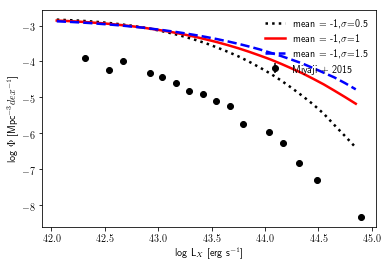

In [40]:
logLxMi,phiM, err = np.loadtxt('Miyaji2015z0.1.txt',skiprows=0,usecols=(0,1,2),unpack=True)
plt.errorbar(logLxMi, np.log10(phiM),yerr=err,fmt='o',label='Miyaji + 2015',color='black')
plt.plot(lglumbins,np.log10(XLFEQ51a_3),color='black',ls=':',linewidth=2.5,label='mean = -1,$\sigma$=0.5')
plt.plot(lglumbins,np.log10(XLFEQ51b_3),color='Red',ls='-',linewidth=2.5,label='mean = -1,$\sigma$=1')
plt.plot(lglumbins,np.log10(XLFEQ51c_3),color='blue',ls='--',linewidth=2.5,label='mean = -1,$\sigma$=1.5')


#plt.plot(lglumbins,np.log10(XLFEQ5a),color='blue',ls='-',linewidth=2.5,label='Aird')
#plt.plot(lglumbins,np.log10(XLFEQ5b),color='grey',ls=':',linewidth=2.5,label='-3.5,0')




plt.legend(loc='upper right', shadow=False, frameon=False)
plt.xlabel(r'log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel(r'log $\Phi$ [Mpc$^{-3} dex^{-1}$]')
#plt.savefig("z0.1/XLFz0.1.png")
plt.show()
plt.close()

In [120]:
flagty2r = np.where((lgNHEQ5 >= 22) & (lgNHEQ5 < 24) )
lgMstarty2 = lgMstarEQ5[flagty2r]
lgMhty2 = lgMhEQ5[flagty2r]
BhMass_EQ5ty2 = BhMass_EQ5[flagty2r]
fEQ5ty2 = fEQ5[flagty2r]
bEQ5ty2 = bEQ5[flagty2r]
logSFRty2 = logSFR[flagty2r]
lglum5ty2 = lglum5cut[flagty2r]
eddty2 = edd5[flagty2r]
lgNHEQ5ty2 = lgNHEQ5[flagty2r]
idh5ty2 = idh5[flagty2r]
xty2 = xEQ5[flagty2r]
yty2 = yEQ5[flagty2r]
zty2 = zEQ5[flagty2r]

In [121]:
flagty1r = np.where((lgNHEQ5 >= 20) & (lgNHEQ5 < 22) )
lgMstarty1 = lgMstarEQ5[flagty1r]
lgMhty1 = lgMhEQ5[flagty1r]
BhMass_EQ5ty1 = BhMass_EQ5[flagty1r]
fEQ5ty1 = fEQ5[flagty1r]
bEQ5ty1 = bEQ5[flagty1r]
logSFRty1 = logSFR[flagty1r]
lglum5ty1 = lglum5cut[flagty1r]
eddty1 = edd5[flagty1r]
lgNHEQ5ty1 = lgNHEQ5[flagty1r]
idh5ty1 = idh5[flagty1r]
xty1 = xEQ5[flagty1r]
yty1 = yEQ5[flagty1r]
zty1 = zEQ5[flagty1r]

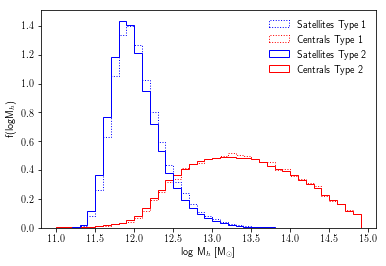

In [122]:
flagsatty1 = np.where(idh5ty1 > 0)
flagcenty1 = np.where(idh5ty1 < 1)
flagsatty2 = np.where(idh5ty2 > 0)
flagcenty2 = np.where(idh5ty2 < 1)


bins = np.arange(11.,15.,0.1)
bins1 = np.arange(11.,14.9,0.1)

#ntot = plt.hist(lgMhEQ5,bins=bins,color='grey',histtype = 'stepfilled')
#n = plt.hist(lgMhEQ5,bins=bins,weights=fEQ5,density=True,color='black',histtype = 'step')
nsatty1 = plt.hist(lgMhty1[flagsatty1],bins=bins,weights=fEQ5ty1[flagsatty1],density=True,color='red',histtype = 'step',linestyle=':')
ncenty1 = plt.hist(lgMhty1[flagcenty1],bins=bins,weights=fEQ5ty1[flagcenty1],density=True,color='blue',histtype = 'step',linestyle=':')
nsatty2 = plt.hist(lgMhty2[flagsatty2],bins=bins,weights=fEQ5ty2[flagsatty2],density=True,color='red',histtype = 'step')
ncenty2 = plt.hist(lgMhty2[flagcenty2],bins=bins,weights=fEQ5ty2[flagcenty2],density=True,color='blue',histtype = 'step')


plt.xlabel(r'log M$_{h}$ [M$_{\odot}$]')
plt.ylabel(r'f(logM$_{h}$)')
handles = [Rectangle((0,0),1,1,facecolor="white",ec="blue",linestyle=':'),Rectangle((0,0),1,1,facecolor="white",ec="red",linestyle=':'),Rectangle((0,0),1,1,facecolor="white",ec="blue"),Rectangle((0,0),1,1,facecolor="white",ec="red")]

labels= ["Satellites Type 1","Centrals Type 1","Satellites Type 2","Centrals Type 2"]
plt.legend(handles, labels,frameon=False,loc='upper right')


#plt.axis([6, 9.5, -6,-1])
plt.savefig("z0.1/flogMhty1_2.eps")
plt.show()
plt.close()




/astro/home/viola.allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in divide


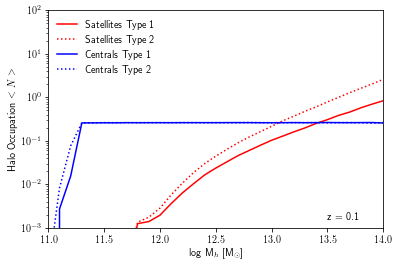

In [44]:
import numpy as np

# Presumably these are just various galaxy subsamples.
flagsatty1 = np.where(idh5ty1 > 0) # flags for satellites in group ty1
flagcenty1 = np.where(idh5ty1 < 1) # flags for centrans in group ty1
flagsatty2 = np.where(idh5ty2 > 0) # etc
flagcenty2 = np.where(idh5ty2 < 1)

# Presumably Halo mass bins - not sure why these need to be different
bins = np.arange(11.,15.,0.1)
bins1 = np.arange(11.,14.9,0.1)

# Presumably this is the unweighted histogram of everything, for comparison purposes.
ntot = np.histogram(lgMhEQ5,bins=bins)

# The histogram of sats in group 1, presumably weighted by the dutycycle. Etc
nsatty1 = np.histogram(lgMhty1[flagsatty1],bins=bins,weights=fEQ5[flagsatty1])
ncenty1 = np.histogram(lgMhty1[flagcenty1],bins=bins,weights=fEQ5[flagcenty1])
nsatty2 = np.histogram(lgMhty2[flagsatty2],bins=bins,weights=fEQ5[flagsatty2])
ncenty2 = np.histogram(lgMhty2[flagcenty2],bins=bins,weights=fEQ5[flagcenty2])

# The same thing, but unweighted?
nsatty1all = np.histogram(lgMhty1[flagsatty1],bins=bins)
ncenty1all = np.histogram(lgMhty1[flagcenty1],bins=bins)
nsatty2all = np.histogram(lgMhty2[flagsatty2],bins=bins)
ncenty2all = np.histogram(lgMhty2[flagcenty2],bins=bins)

# Everything in this section is just extractning the actual histogram elements
hod = ntot[0]

hodty1sat = nsatty1[0]
hodty1cen = ncenty1[0]

hodty2sat = nsatty2[0]
hodty2cen = ncenty2[0]

hodty1satall = nsatty1all[0]
hodty1cenall = ncenty1all[0]

hodty2satall = nsatty2all[0]
hodty2cenall = ncenty2all[0]

# Various conditions that compare to the bins, presumably setting data above/below certain thresholds.
t = np.where(bins1 <=11.7 )
h = np.where(bins1 >11.2 )
l = np.where(bins1 <=11.2 )


rapcenty1 = np.zeros(len(bins1))
rapsatty1 = np.float64(hodty1sat)/np.float64(hodty1cenall)
rapsatty1[t] = 0.0001

rapcenty1[h] = np.float64(hodty1cen[h])/np.float64(hodty1cenall[h]) 
rapcenty1[l] = np.float64(hodty1cen[l])/np.float64(hod[l]) 

rapcenty2 = np.zeros(len(bins1))
rapsatty2 = np.float64(hodty2sat)/np.float64(hodty2cenall)
rapsatty2[t] = 0.0001
rapcenty2[h] = np.float64(hodty2cen[h])/np.float64(hodty2cenall[h]) 
rapcenty2[l] = np.float64(hodty2cen[l])/np.float64(hod[l]) 


totty1 = rapsatty1 + rapcenty1
totty2 = rapsatty2 + rapcenty2



pyplot.yscale('log',nonposy='clip')
#plt.plot(bins1,totty1,color='k',linewidth=3.,label=r'Total Type 1',linestyle='-')
#plt.plot(bins1,totty2,color='k',linewidth=2.,label=r'Total Type 2',linestyle=':')
plt.plot(bins1,rapsatty1,color='r',linewidth=1.5,linestyle='-',label=r'Satellites Type 1')
plt.plot(bins1,rapsatty2,color='r',linewidth=1.5,linestyle=':',label=r'Satellites Type 2')
plt.plot(bins1,rapcenty1,color='b',linewidth=1.5,label=r'Centrals Type 1',linestyle='-',)
plt.plot(bins1,rapcenty2,color='b',linewidth=1.5,label=r'Centrals Type 2',linestyle=':')
plt.xlabel(r'log M$_{h}$ [M$_{\odot}$]')
plt.ylabel(r'Halo Occupation $<N>$')
legend = plt.legend(loc='upper left', shadow=False, frameon=False)
plt.axis([11., 14., 10.**(-3),10.**(2.)])
plt.text(13.5, 10.**(-2.8), r'z = 0.1')




plt.savefig("z0.1/HODtyp1_2.eps")
plt.show()
plt.close()




In [160]:
#import weightedstats as ws


Mstarbin = np.arange(9.,12.,0.3)

medianbiasstarAGNty1 = np.zeros(len(Mstarbin))
medianbiasstarAGNty2 = np.zeros(len(Mstarbin))

errstarAGNty1 = np.zeros(len(Mstarbin))
errstarAGNty2 = np.zeros(len(Mstarbin))

medianMhstarAGNty1 = np.zeros(len(Mstarbin))
medianMhstarAGNty2 = np.zeros(len(Mstarbin))

errMhstarAGNty1 = np.zeros(len(Mstarbin))
errMhstarAGNty2 = np.zeros(len(Mstarbin))





for i in range(len(Mstarbin)-1):
    
    
    N1 = np.where(((lgMstarty2) >= Mstarbin[i]) & ((lgMstarty2) < Mstarbin[i+1]))
    medianbiasstarAGNty2[i] = np.sum(bEQ5ty2[N1]*fEQ5ty2[N1])/np.sum(fEQ5ty2[N1])
    #ws.weighted_median(bEQ5ty2[N1], weights=fEQ5ty2[N1])
    errstarAGNty2[i] = np.std(bEQ5ty2[N1])

    N1 = np.where(((lgMstarty1) >= Mstarbin[i]) & ((lgMstarty1) < Mstarbin[i+1]))
    medianbiasstarAGNty1[i] = np.sum(bEQ5ty1[N1]*fEQ5ty1[N1])/np.sum(fEQ5ty1[N1])
    #ws.weighted_median(bEQ5ty2[N1], weights=fEQ5ty2[N1])
    errstarAGNty1[i] = np.std(bEQ5ty1[N1])


    N1 = np.where(((lgMstarty2) >= Mstarbin[i]) & ((lgMstarty2) < Mstarbin[i+1]))
    medianMhstarAGNty2[i] = np.sum(lgMhty2[N1]*fEQ5ty2[N1])/np.sum(fEQ5ty2[N1])
    #ws.weighted_median(lgMhty2[N1], weights=fEQ5ty2[N1])
    errMhstarAGNty2[i] = np.std(lgMhty2[N1])

    N1 = np.where(((lgMstarty1) >= Mstarbin[i]) & ((lgMstarty1) < Mstarbin[i+1]))
    medianMhstarAGNty1[i] = np.sum(lgMhty1[N1]*fEQ5ty1[N1])/np.sum(fEQ5ty1[N1])
    #ws.weighted_median(lgMhty2[N1], weights=fEQ5ty2[N1])
    errMhstarAGNty1[i] = np.std(lgMhty1[N1])




In [159]:
print medianMhstarAGNty2

[12.21394954 12.28993073 12.37315706 12.45940589 12.55929614 12.66123379
 12.77676416 12.90097256 13.04574172 13.20888089 13.40943191 13.63004585
 13.8688581   0.        ]


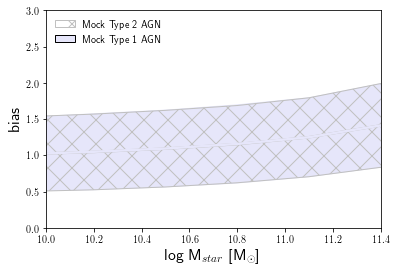

In [169]:
from matplotlib.patches import Rectangle

a = plt.plot(Mstarbin,medianbiasstarAGNty2,color='silver',linewidth=2.5, linestyle='-')
b = plt.plot(Mstarbin,medianbiasstarAGNty1,color='lavender',linewidth=2.5, linestyle='-')
plt.fill_between(Mstarbin,medianbiasstarAGNty1+errstarAGNty1,medianbiasstarAGNty1-errstarAGNty1,color='lavender')
plt.fill_between(Mstarbin,medianbiasstarAGNty2+errstarAGNty2,medianbiasstarAGNty2-errstarAGNty2,facecolor='none',hatch='x',edgecolor='silver')

handles = [Rectangle((0,0),1,1,facecolor="white",ec="silver",hatch="x"),Rectangle((0,0),1,1,color="lavender",ec="k"),a[0],b[0]]
labels= ["Mock Type 2 AGN", "Mock Type 1 AGN"]

plt.legend(handles, labels,frameon=False,loc='upper left')

#plt.text(14.5, 6.8, r'z = 1.5')
#plt.errorbar(lgMBH, b, yerr=berrup,fmt='o',color='black')
#legend = plt.legend(loc='upper left', shadow=False, frameon=False)
plt.xlabel(r'log M$_{star}$ [M$_{\odot}$]',fontsize='16')
plt.ylabel(r'bias',fontsize='16')
plt.axis([10.,11.4,0.,3.])
plt.savefig("z0.1/bvsMstar.png")
plt.show()
plt.close()


In [134]:
MBHbin = np.arange(6.,10.,0.3)

medianbiasstarAGNty1 = np.zeros(len(MBHbin))
medianbiasstarAGNty2 = np.zeros(len(MBHbin))

errstarAGNty1 = np.zeros(len(MBHbin))
errstarAGNty2 = np.zeros(len(MBHbin))

medianMhstarAGNty1 = np.zeros(len(MBHbin))
medianMhstarAGNty2 = np.zeros(len(MBHbin))

errMhstarAGNty1 = np.zeros(len(MBHbin))
errMhstarAGNty2 = np.zeros(len(MBHbin))





for i in range(len(MBHbin)-1):
    
    
    N1 = np.where(((BhMass_EQ5ty2) >= MBHbin[i]) & ((BhMass_EQ5ty2) < MBHbin[i+1]))
    medianbiasstarAGNty2[i] = np.sum(bEQ5ty2[N1]*fEQ5ty2[N1])/np.sum(fEQ5ty2[N1])
    #ws.weighted_median(bEQ5ty2[N1], weights=fEQ5ty2[N1])
    errstarAGNty2[i] = np.std(bEQ5ty2[N1])

    N1 = np.where(((BhMass_EQ5ty1) >= MBHbin[i]) & ((BhMass_EQ5ty1) < MBHbin[i+1]))
    medianbiasstarAGNty1[i] = np.sum(bEQ5ty1[N1]*fEQ5ty1[N1])/np.sum(fEQ5ty1[N1])
    #ws.weighted_median(bEQ5ty2[N1], weights=fEQ5ty2[N1])
    errstarAGNty1[i] = np.std(bEQ5ty1[N1])


    N1 = np.where(((BhMass_EQ5ty2) >= MBHbin[i]) & ((BhMass_EQ5ty2) < MBHbin[i+1]))
    medianMhstarAGNty2[i] = np.sum(lgMhty2[N1]*fEQ5ty2[N1])/np.sum(fEQ5ty2[N1])
    #ws.weighted_median(lgMhty2[N1], weights=fEQ5ty2[N1])
    errMhstarAGNty2[i] = np.std(lgMhty2[N1])

    N1 = np.where(((BhMass_EQ5ty1) >= MBHbin[i]) & ((BhMass_EQ5ty1) < MBHbin[i+1]))
    medianMhstarAGNty1[i] = np.sum(lgMhty1[N1]*fEQ5ty1[N1])/np.sum(fEQ5ty1[N1])
    #ws.weighted_median(lgMhty2[N1], weights=fEQ5ty2[N1])
    errMhstarAGNty1[i] = np.std(lgMhty1[N1])




In [135]:
print medianMhstarAGNty1

[12.21875832 12.29112418 12.37487056 12.463364   12.55877628 12.65854218
 12.77541252 12.90212544 13.04846259 13.22049088 13.41269172 13.64456519
 13.86029148  0.        ]


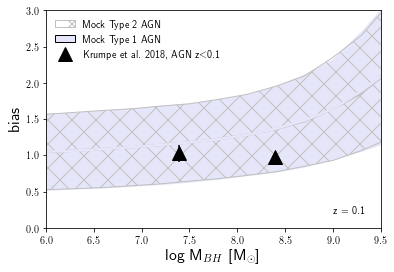

In [157]:
from matplotlib.patches import Rectangle

bKru18 = [1.03, 0.98]
errbKru18 = [0.12,0.03]
BHKru18 = [7.39, 8.39]
plt.plot(MBHbin,medianbiasstarAGNty2,color='silver',linewidth=2.5, linestyle='-')
plt.plot(MBHbin,medianbiasstarAGNty1,color='lavender',linewidth=2.5, linestyle='-')
plt.fill_between(MBHbin,medianbiasstarAGNty1+errstarAGNty1,medianbiasstarAGNty1-errstarAGNty1,color='lavender')
plt.fill_between(MBHbin,medianbiasstarAGNty2+errstarAGNty2,medianbiasstarAGNty2-errstarAGNty2,facecolor='none',hatch='x',edgecolor='silver')
c = plt.errorbar(BHKru18, bKru18, yerr=errbKru18,fmt='^',ms='14',color='black')


handles = [Rectangle((0,0),1,1,facecolor="white",ec="silver",hatch="x"),Rectangle((0,0),1,1,color="lavender",ec="k"),c[0]]
labels= ["Mock Type 2 AGN", "Mock Type 1 AGN","Krumpe et al. 2018, AGN z$<$0.1"]

plt.legend(handles, labels,frameon=False,loc='upper left')

plt.text(9., 0.2, r'z = 0.1')
#plt.errorbar(lgMBH, b, yerr=berrup,fmt='o',color='black')
#legend = plt.legend(loc='upper left', shadow=False, frameon=False)
plt.xlabel(r'log M$_{BH}$ [M$_{\odot}$]',fontsize='16')
plt.ylabel(r'bias',fontsize='16')
plt.axis([6.,9.5,0.,3.])
plt.savefig("z0.1/bvsMBH.png")
plt.show()
plt.close()

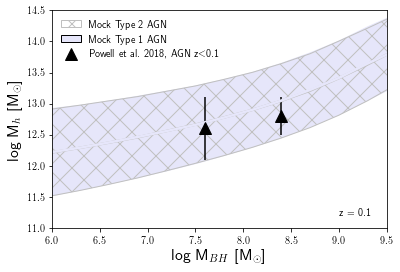

In [156]:
from matplotlib.patches import Rectangle

MBHPow = [7.6,8.4]
MhPow = [12.6,12.8]
errupMhPow = [0.5,0.3]
#errdwMhPow = [0.9,0.4]


plt.plot(MBHbin,medianMhstarAGNty2,color='silver',linewidth=2.5, linestyle='-')
plt.plot(MBHbin,medianMhstarAGNty1,color='lavender',linewidth=2.5, linestyle='-')
plt.fill_between(MBHbin,medianMhstarAGNty1+errMhstarAGNty1,medianMhstarAGNty1-errMhstarAGNty1,color='lavender')
plt.fill_between(MBHbin,medianMhstarAGNty2+errMhstarAGNty2,medianMhstarAGNty2-errMhstarAGNty2,facecolor='none',hatch='x',edgecolor='silver')
c = plt.errorbar(MBHPow, MhPow, yerr=errupMhPow,fmt='^',color='black',ms=12)

handles = [Rectangle((0,0),1,1,facecolor="white",ec="silver",hatch="x"),Rectangle((0,0),1,1,color="lavender",ec="k"),c[0]]
labels= ["Mock Type 2 AGN", "Mock Type 1 AGN","Powell et al. 2018, AGN z$<$0.1"]

plt.legend(handles, labels,frameon=False,loc='upper left')

plt.text(9., 11.2, r'z = 0.1')
#plt.errorbar(lgMBH, b, yerr=berrup,fmt='o',color='black')
#legend = plt.legend(loc='upper left', shadow=False, frameon=False)
plt.xlabel(r'log M$_{BH}$ [M$_{\odot}$]',fontsize='16')
plt.ylabel(r'log M$_h$ [M$_{\odot}$]',fontsize='16')
plt.axis([6.,9.5,11.,14.5])
plt.savefig("z0.1/MhvsMBH.png")
plt.show()
plt.close()

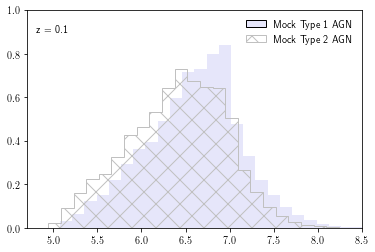

In [48]:
#plt.hist(np.log10(10.**lglum5cut/10.**lgMstarEQ5),bins=40,color='blue',histtype = 'stepfilled',label='Eq5')
#plt.show()
a = plt.hist(BhMass_EQ5ty1,bins=40,weights=fEQ5ty1,density=True,color='lavender',histtype = 'stepfilled',label='Type 1')
b = plt.hist(BhMass_EQ5ty2,bins=40,weights=fEQ5ty2,density=True,color='silver',hatch='x',histtype = 'step',label='Type 2')
handles = [Rectangle((0,0),1,1,color="lavender",ec="k"),Rectangle((0,0),1,1,facecolor="white",ec="silver",hatch="x"),a[0],b[0]]

labels= ["Mock Type 1 AGN", "Mock Type 2 AGN"]
plt.legend(handles, labels,frameon=False,loc='upper right')
plt.text(4.8, 0.9, r'z = 0.1')

plt.axis([4.7,8.5,0.,1.])


plt.savefig("z0.1/MBHdistrty1_2.png")
plt.show()
plt.close()


#plt.show()
#plt.hist(lgMstarEQ5,bins=40,color='blue',histtype = 'stepfilled',label='Eq5')
#plt.show()
#plt.hist(lglum5cut,bins=40,color='blue',histtype = 'stepfilled',label='Eq5')
#plt.hist(lglum5gaucut,bins=40,color='red',histtype = 'step',label='Eq5')
#plt.show()

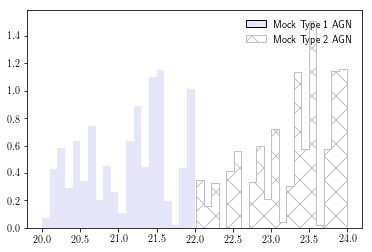

In [118]:
a = plt.hist(lgNHEQ5ty1,bins=20,weights=fEQ5ty1,density=True,color='lavender',histtype = 'stepfilled',label='Type 1')
b = plt.hist(lgNHEQ5ty2,bins=20,weights=fEQ5ty2,density=True,color='silver',hatch='x',histtype = 'step',label='Type 2')
handles = [Rectangle((0,0),1,1,color="lavender",ec="k"),Rectangle((0,0),1,1,facecolor="white",ec="silver",hatch="x"),a[0],b[0]]
labels= ["Mock Type 1 AGN", "Mock Type 2 AGN"]
plt.legend(handles, labels,frameon=False,loc='upper right')


plt.savefig("z0.1/NHdistrty1_2.png")
plt.show()
plt.close()



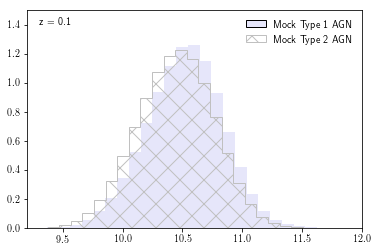

In [49]:
a=plt.hist(lgMstarty1,bins=40,weights=fEQ5ty1,density=True,color='lavender',histtype = 'stepfilled',label='Type 1')
b=plt.hist(lgMstarty2,bins=40,weights=fEQ5ty2,density=True,color='silver',hatch='x',histtype = 'step',label='Type 2')
handles = [Rectangle((0,0),1,1,color="lavender",ec="k"),Rectangle((0,0),1,1,facecolor="white",ec="silver",hatch="x"),a[0],b[0]]
labels= ["Mock Type 1 AGN", "Mock Type 2 AGN"]
plt.legend(handles, labels,frameon=False,loc='upper right')

plt.text(9.3, 1.4, r'z = 0.1')

plt.axis([9.2,12.,0.,1.5])


plt.savefig("z0.1/Mstardistrty1_2.png")
plt.show()
plt.close()



In [98]:
nthreads = 8

pi_max = 50

bins = numpy.linspace(0.1, 30, 100)

period = 1000
wp_results = wp(period, pi_max, nthreads, bins, xEQ5, yEQ5, zEQ5,  weights=fEQ5, weight_type='pair_product',verbose = True)
wrpEQ5AGN = wp_results['wp']

In gridlink_index_particles_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,20.  Time taken =   1.651 sec
countpairs_wp_double> gridlink seems inefficient. nmesh = (33, 33, 20); avg_np = 453. Boosting bin refine factor - should lead to better performance
xmin = 0.000000 xmax=1000.000000 rpmax = 30.000000
In gridlink_index_particles_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 66,66,20.  Time taken =   1.741 sec
Using fallback kernel
0%.........10%.........20%.........30%.........40%.........Received signal = `Interrupt' (signo = 2). Aborting 


RuntimeError: RuntimeError occurred

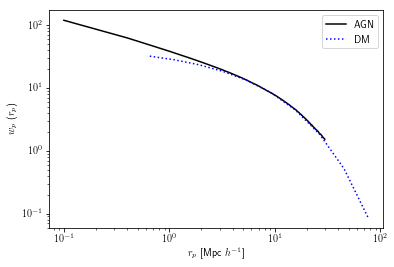

In [79]:
pyplot.figure()
pyplot.xscale('log')
pyplot.yscale('log',nonposy='clip')
rpDM, wpDM = np.loadtxt('wrp_dm_EisensteinHu_pimax40.000000_z1.000000.txt',skiprows=0,usecols=(0,1),unpack=True)
#pyplot.plot(bins[0:-1], wrpEQ4low, label = "Eq4",color='red')
pyplot.plot(bins[0:-1], wrpEQ5AGN, label = "AGN",color='black')
pyplot.plot(rpDM, wpDM*1.2*1.2, label = "DM",color='blue',linestyle=':')


#plt.errorbar(rpKru,wpKru, yerr=50,fmt='o',color='black',label='Krumpe + 2015')
 
    
pyplot.xlabel(r"$r_p$ [Mpc $h^{-1}$]")
pyplot.ylabel(r"$w_p$ ($r_p$)")
pyplot.legend()
pyplot.savefig("z0.1/wrpAGN.png")
pyplot.show()
pyplot.close()

np.savetxt('z0.1/wpAGN.txt',np.column_stack((bins[0:-1],wrpEQ5AGN)))       



In [72]:
nthreads = 8

pi_max = 50

bins = numpy.linspace(0.1, 30, 100)

period = 1000
wp_results = wp(period, pi_max, nthreads, bins, xty1, yty1, zty1,  weights=fEQ5ty1, weight_type='pair_product',verbose = True)
wrpEQ5ty1 = wp_results['wp']

In gridlink_index_particles_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,20.  Time taken =   0.338 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.798 secs


In [73]:
nthreads = 8

pi_max = 50

bins = numpy.linspace(0.1, 30, 100)

period = 1000
wp_results = wp(period, pi_max, nthreads, bins, xty2, yty2, zty2,  weights=fEQ5ty2, weight_type='pair_product',verbose = True)
wrpEQ5ty2 = wp_results['wp']

In gridlink_index_particles_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,20.  Time taken =   0.906 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =     2 mins   40 secs


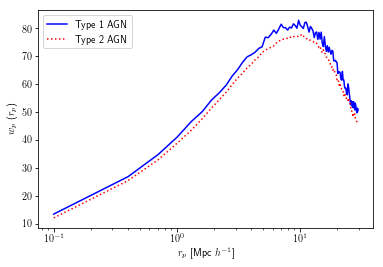

In [89]:
pyplot.figure()
pyplot.xscale('log')
#pyplot.yscale('log',nonposy='clip')

#pyplot.plot(bins[0:-1], wrpEQ4low, label = "Eq4",color='red')
pyplot.plot(bins[0:-1], bins[0:-1]*wrpEQ5ty1, label = "Type 1 AGN",color='blue',linestyle='-')
pyplot.plot(bins[0:-1], bins[0:-1]*wrpEQ5ty2, label = "Type 2 AGN",color='red',linestyle=':')
#pyplot.plot(rpDM, rpDM*wpDM, label = "b2*DM",color='black')


#plt.errorbar(rpKru,wpKru, yerr=50,fmt='o',color='black',label='Krumpe + 2015')
 
    
pyplot.xlabel(r"$r_p$ [Mpc $h^{-1}$]")
pyplot.ylabel(r"$w_p$ ($r_p$)")
pyplot.legend()
pyplot.savefig("z0.1/wrpty1_2.png")
pyplot.show()
pyplot.close()

np.savetxt('z0.1/wpAGNty1.txt',np.column_stack((bins[0:-1],wrpEQ5ty1)))       
np.savetxt('z0.1/wpAGNty2.txt',np.column_stack((bins[0:-1],wrpEQ5ty2)))       




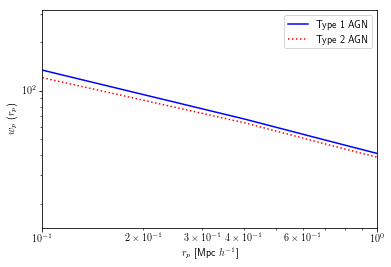

In [87]:
pyplot.figure()
pyplot.xscale('log')
pyplot.yscale('log',nonposy='clip')

#pyplot.plot(bins[0:-1], wrpEQ4low, label = "Eq4",color='red')
pyplot.plot(bins[0:-1], wrpEQ5ty1, label = "Type 1 AGN",color='blue',linestyle='-')
pyplot.plot(bins[0:-1], wrpEQ5ty2, label = "Type 2 AGN",color='red',linestyle=':')

#pyplot.plot(rpDM, wpDM*1.11*1.11, label = "b2*DM",color='blue')


#plt.errorbar(rpKru,wpKru, yerr=50,fmt='o',color='black',label='Krumpe + 2015')
 
    
pyplot.xlabel(r"$r_p$ [Mpc $h^{-1}$]")
pyplot.ylabel(r"$w_p$ ($r_p$)")
plt.axis([10.**(-1), 10.**(0),10.**(1.15), 10.**2.5])
pyplot.legend()
pyplot.savefig("wrpty1_2a.png")
pyplot.show()
pyplot.close()



In [129]:
eddbin = np.arange(-1.5,0.,0.2)

medianbiaseddAGNty2 = np.zeros(len(eddbin))
medianbiaseddAGNty1 = np.zeros(len(eddbin))



erreddAGNty2 = np.zeros(len(eddbin))
erreddAGNty1 = np.zeros(len(eddbin))



for i in range(len(eddbin)-1):
    
    
    N1 = np.where(((eddty2) >= eddbin[i]) & ((eddty2) < eddbin[i+1]))
    medianbiaseddAGNty2[i] = np.sum(bEQ5ty2[N1]*fEQ5ty2[N1])/np.sum(fEQ5ty2[N1])
    erreddAGNty2[i] = np.std(bEQ5ty2[N1])

    N1 = np.where(((eddty1) >= eddbin[i]) & ((eddty1) < eddbin[i+1]))
    medianbiaseddAGNty1[i] = np.sum(bEQ5ty1[N1]*fEQ5ty1[N1])/np.sum(fEQ5ty1[N1])
    erreddAGNty1[i] = np.std(bEQ5ty1[N1])



#np.savetxt('bvseddcut12.txt',np.column_stack((eddbin,medianbiaseddAGN,erreddAGN))) 




/astro/home/viola.allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/astro/home/viola.allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


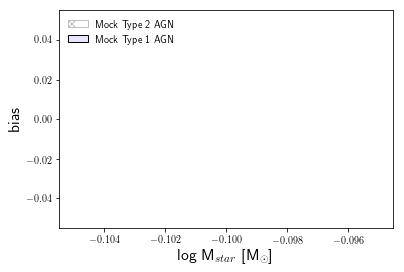

In [130]:
from matplotlib.patches import Rectangle


a = plt.plot(eddbin,medianbiaseddAGNty2,color='silver',linewidth=2.5, linestyle='-')
b = plt.plot(eddbin,medianbiaseddAGNty1,color='lavender',linewidth=2.5, linestyle='-')
plt.fill_between(eddbin,medianbiaseddAGNty1+erreddAGNty1,medianbiaseddAGNty1-erreddAGNty1,color='lavender')
plt.fill_between(eddbin,medianbiaseddAGNty2+erreddAGNty2,medianbiaseddAGNty2-erreddAGNty2,facecolor='none',hatch='x',edgecolor='silver')

handles = [Rectangle((0,0),1,1,facecolor="white",ec="silver",hatch="x"),Rectangle((0,0),1,1,color="lavender",ec="k"),a[0],b[0]]
labels= ["Mock Type 2 AGN", "Mock Type 1 AGN"]

plt.legend(handles, labels,frameon=False,loc='upper left')

#plt.text(14.5, 6.8, r'z = 1.5')
#plt.errorbar(lgMBH, b, yerr=berrup,fmt='o',color='black')
#legend = plt.legend(loc='upper left', shadow=False, frameon=False)
plt.xlabel(r'log M$_{star}$ [M$_{\odot}$]',fontsize='16')
plt.ylabel(r'bias',fontsize='16')
#plt.axis([6.,9.5,0.,3.])
plt.savefig("z0.1/bvsedd.png")
plt.show()
plt.close()

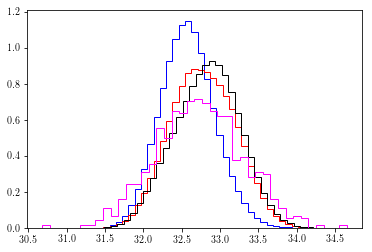

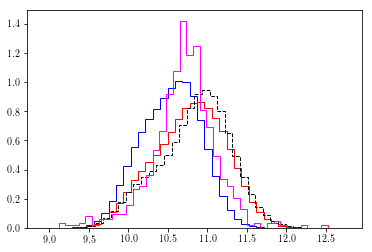

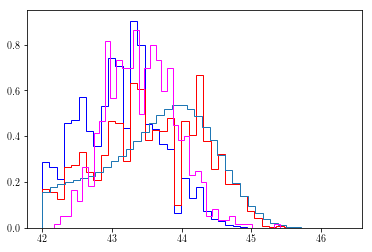

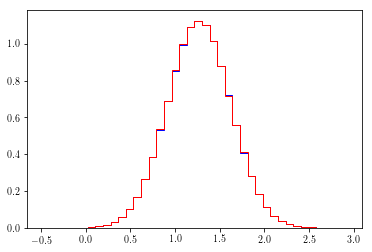

In [305]:
Mstar, Lx, edd = np.loadtxt('CCLXMMAGNfluxspeczlohiMSFR.txt',skiprows=0,usecols=(8,14,15),unpack=True)

plt.hist(np.log10(10.**lglum5ty2/10.**lgMstarty2),density=True,weights=fEQ5ty2,bins=40,color='blue',histtype = 'step',label='Ty2')
plt.hist(np.log10(10.**lglum5ty2/10.**lgMstarty2),density=True,weights=fgalEQ5ty2,bins=40,color='red',histtype = 'step',label='Gal')
plt.hist(np.log10(10.**lglumCCLXMM/10.**lgMstarCCLXMM),density=True,weights=fgalCCLXMM,bins=40,color='black',histtype = 'step',label='Gal')
plt.hist(edd,density=True,bins=40,color='magenta',histtype = 'step',label='CCLXMM AGN')

plt.show()

plt.hist(lgMstarty2,bins=40,color='blue',density=True,weights=fEQ5ty2,histtype = 'step',label='Eq5')
plt.hist(lgMstarty2,bins=40,color='red',density=True,weights=fgalEQ5ty2,histtype = 'step',label='Eq5')
plt.hist(lgMstarCCLXMM,bins=40,color='black',density=True,weights=fgalCCLXMM,linestyle = '--',histtype = 'step',label='Eq5')
plt.hist(Mstar,density=True,bins=40,color='magenta',histtype = 'step',label='CCLXMM AGN')


plt.show()

plt.hist(lglum5ty2,bins=40,color='blue',density=True,weights=fEQ5ty2,histtype = 'step',label='Eq5')
plt.hist(lglum5ty2,bins=40,color='red',density=True,weights=fgalEQ5ty2,histtype = 'step',label='Eq5')
plt.hist(lglumCCLXMM,bins=40,density=True,weights=fgalCCLXMM,histtype = 'step',label='Eq5')
plt.hist(Lx,density=True,bins=40,color='magenta',histtype = 'step',label='CCLXMM AGN')

plt.show()
plt.hist(logSFRty2,bins=40,color='blue',density=True,weights=fEQ5ty2,histtype = 'step',label='Eq5')
plt.hist(logSFRty2,bins=40,color='red',density=True,weights=fgalEQ5ty2,histtype = 'step',label='Eq5')
plt.show()

In [302]:
import weightedstats as ws


Mstarbin = np.arange(9.,12.,0.3)

medianbiasstarAGN = np.zeros(len(Mstarbin))
medianbiasstargal= np.zeros(len(Mstarbin))
medianbiasstargalty2= np.zeros(len(Mstarbin))


errstarAGN = np.zeros(len(Mstarbin))
errstargal = np.zeros(len(Mstarbin))
errstargalty2 = np.zeros(len(Mstarbin))



medianMhstarAGN = np.zeros(len(Mstarbin))
medianMhstargal= np.zeros(len(Mstarbin))
medianMhstargalty2= np.zeros(len(Mstarbin))


errMhstarAGN = np.zeros(len(Mstarbin))
errMhstargal = np.zeros(len(Mstarbin))
errMhstargalty2 = np.zeros(len(Mstarbin))



for i in range(len(Mstarbin)-1):
    
    
    N1 = np.where(((lgMstarty2) >= Mstarbin[i]) & ((lgMstarty2) < Mstarbin[i+1]))
    medianbiasstarAGN[i] = np.sum(bEQ5ty2[N1]*fEQ5ty2[N1])/np.sum(fEQ5ty2[N1])
    #ws.weighted_median(bEQ5ty2[N1], weights=fEQ5ty2[N1])
    errstarAGN[i] = np.std(bEQ5ty2[N1])/2.


#np.savetxt('bvsMstarcut12.txt',np.column_stack((Mstarbin,medianbiasstarAGN,errstarAGN))) 




In [453]:
lgSFRbin = np.arange(0,3.,0.25)

medianMhSFRAGN = np.zeros(len(lgSFRbin))
medianMhSFRgal= np.zeros(len(lgSFRbin))

errMhSFRAGN = np.zeros(len(lgSFRbin))
errMhSFRgal = np.zeros(len(lgSFRbin))


for i in range(len(lgSFRbin)-1):
    
    N1 = np.where(((logSFRty2) >= lgSFRbin[i]) & ((logSFRty2) < lgSFRbin[i+1]))
    medianMhSFRAGN[i] = np.sum(lgMhty2[N1]*fEQ5ty2[N1])/np.sum(fEQ5ty2[N1])
    errMhSFRAGN[i] = np.std(lgMhty2[N1])/1.5

    
    N1 = np.where(((logSFRty2) >= lgSFRbin[i]) & ((logSFRty2) < lgSFRbin[i+1]))
    medianMhSFRgal[i] = np.sum(lgMhty2[N1]*(fgalEQ5ty2[N1]))/np.sum(fgalEQ5[N1])
    errMhSFRgal[i] = np.std(lgMhty2[N1])/1.5



/Users/allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


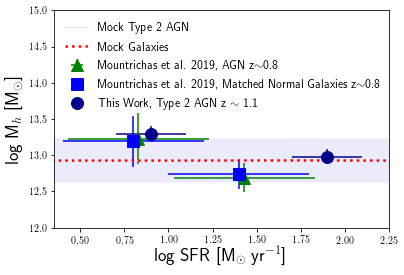

In [454]:
SFR = [0.83,1.43]
halo = [13.23,12.69]
errSFR = [0.35,0.20]

SFR2 = [0.8,1.4]
halo2 = [13.19,12.74]
errSFR2 = [0.35,0.20]

SFR1 = [0.9,1.9]
halo1 = [13.3,12.98]
errSFR1 = [0.1,0.1]
SFRBe,MhaloBe = np.loadtxt('Bethermin2.txt',skiprows=0,usecols=(0,1),unpack=True)
errBe = [[0.2,0.3],[0.2,0.4]]

plt.errorbar(SFR, halo, yerr=errSFR,xerr=0.4,fmt='^',color='green',ms=12,label='Mountrichas et al. 2019, AGN z$\sim$0.8')
plt.fill_between(lgSFRbin,medianMhSFRAGN+errMhSFRAGN,medianMhSFRAGN-errMhSFRAGN,facecolor='lavender',edgecolor='lavender',alpha=0.8)
#plt.errorbar(np.log10(SFRBe)-0.08,MhaloBe,errBe,fmt='p',color='red',ms=12,label='Bethermin et al. 2014, Normal Galaxies z=2')
plt.plot(lgSFRbin,medianMhSFRAGN,color='lavender',linewidth=1., linestyle='-',label='Mock Type 2 AGN')
plt.plot(lgSFRbin,medianMhSFRAGN,color='red',linewidth=2.5, linestyle=':',label='Mock Galaxies')



plt.errorbar(SFR2, halo2, yerr=errSFR2,xerr=0.4,fmt='s',color='blue',ms=12,label='Mountrichas et al. 2019, Matched Normal Galaxies z$\sim$0.8')
plt.errorbar(SFR1, halo1,yerr=errSFR1,xerr=0.2,fmt='o',color='darkblue',ms=12,label='This Work, Type 2 AGN z $\sim$ 1.1')
legend = plt.legend(loc='upper left', shadow=False, frameon=False,fontsize=12)
plt.xlabel(r'log SFR [M$_{\odot}$ yr$^{-1}$]',fontsize='18')
plt.ylabel(r'log M$_{h}$ [M$_{\odot}$]',fontsize='18')
plt.axis([0.35,2.25,12,15])
plt.savefig("MhvsSFR.png")
plt.show()
plt.close()



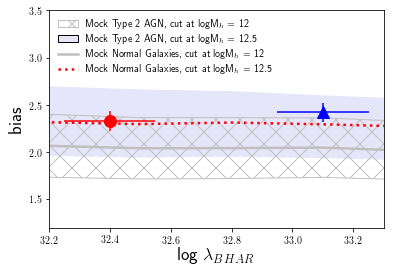

In [443]:
edd, bias, err = np.loadtxt('bvseddcut12.txt',skiprows=0,usecols=(0,1,2),unpack=True)


a = plt.plot(eddbin,medianbiaseddgal,color='red',linewidth=2.5, linestyle=':')
b = plt.plot(eddbin,bias,color='silver',linewidth=2.5, linestyle='-')
plt.fill_between(eddbin,medianbiaseddAGN+erreddAGN,medianbiaseddAGN-erreddAGN,facecolor='lavender',edgecolor='lavender')
plt.fill_between(edd,bias+err,bias-err,facecolor='none',hatch='x',edgecolor='silver')
plt.errorbar(32.4, 2.33, yerr=0.11,xerr = 0.15,fmt='o',color='red',ms=12,label='low $\lambda_{BHAR}$')
plt.errorbar(33.1, 2.42, yerr=0.10,xerr = 0.15,fmt='^',color='blue',ms=12,label='high $\lambda_{BHAR}$')
handles = [Rectangle((0,0),1,1,facecolor="white",edgecolor="silver",hatch="x"),Rectangle((0,0),1,1,color="lavender",ec="k"),b[0],a[0]]
labels= ["Mock Type 2 AGN, cut at logM$_h$ = 12","Mock Type 2 AGN, cut at logM$_h$ = 12.5","Mock Normal Galaxies, cut at logM$_h$ = 12","Mock Normal Galaxies, cut at logM$_h$ = 12.5"]
plt.legend(handles, labels,frameon=False,loc='upper left')

#legend = plt.legend(loc='upper left', shadow=False, frameon=False)
plt.xlabel(r'log $\lambda_{BHAR}$',fontsize='18')
plt.ylabel(r'bias',fontsize='18')
plt.axis([32.2,33.3,1.2,3.5])

plt.savefig("bvsedd.png")
plt.show()
plt.close()



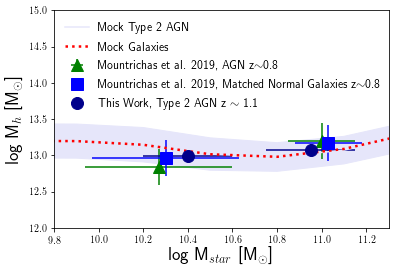

In [444]:
gal = [10.27,11.00]
halo = [12.84,13.2]
errgal = [0.33,0.15]
#plt.style.use('classic')

gal2 = [10.3,11.03]
halo2 = [12.96,13.17]
errgal2 = [0.33,0.15]

M = [10.4,10.95]
Mh = [12.99,13.07]
upMh = [0.07,0.08]



plt.plot(Mstarbin,medianMhstarAGN,color='lavender',linewidth=1.5, linestyle='-',label='Mock Type 2 AGN',ms=12)
plt.plot(Mstarbin,medianMhstargal,color='red',linewidth=2.5, linestyle=':',label='Mock Galaxies',ms=12)
plt.fill_between(Mstarbin,medianMhstarAGN+errMhstarAGN,medianMhstarAGN-errMhstarAGN,facecolor='lavender',edgecolor='lavender')
#plt.fill_between(Mstarbin,medianMhstargal+errMhstargal,medianMhstargal-errMhstargal,color='silver',hatch='x',facecolor='none')
#handles = [Rectangle((0,0),1,1,facecolor="white",ec="silver",hatch="x"),Rectangle((0,0),1,1,color="lavender",ec="k")]
#labels= ["Mock AGN, cut at logM$_h$ = 12","Mock AGN, cut at logM$_h$ = 12.5"]
plt.legend(handles, labels,frameon=False,loc='upper left')
#plt.errorbar(np.log10(logMstar_wake), np.log10(logMhalo_wake), yerr=0.02,fmt='p',color='orange',ms=12,label='Wake + 2011, Normal Galaxies z $\sim$ 1.1')
#plt.errorbar(np.log10(logMstar_zheng), np.log10(logMhalo_zheng), yerr=0.06,fmt='*',color='black',ms=12,label='Zheng + 2007, Normal Galaxies z $\sim$ 1')

plt.errorbar(gal, halo, yerr=0.25,xerr=errgal,fmt='^',color='green',ms=12,label='Mountrichas et al. 2019, AGN z$\sim$0.8')
plt.errorbar(gal2, halo2, yerr=0.25,xerr=errgal2,fmt='s',color='blue',ms=12,label='Mountrichas et al. 2019, Matched Normal Galaxies z$\sim$0.8')

plt.errorbar(M, Mh, yerr=upMh,xerr=0.2,fmt='o',color='darkblue',ms=12,label='This Work, Type 2 AGN z $\sim$ 1.1')
plt.legend(loc='upper left', shadow=False, frameon=False,fontsize=12)

plt.xlabel(r'log M$_{star}$ [M$_{\odot}$]',fontsize='18')
plt.ylabel(r'log M$_{h}$ [M$_{\odot}$]',fontsize='18')
plt.axis([9.8,11.3,12.,15.])
plt.savefig("MhvsMstar.png")
plt.show()
plt.close()
